In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import logging
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib
import os

# Задание путей для сохранения данных, изображений, весов и скриптов
save_dir = "..\\data"      # Папка для данных
save_dir2 = "..\\images"   # Папка для изображений
save_dir3 = "..\\weights"  # Папка для весов (если будут)
save_dir4 = "..\\scripts"  # Папка для скриптов (если будет использоваться)

# Чтение файла данных
file_path = os.path.join(save_dir, "final_result_dataset.csv")
data = pd.read_csv(file_path, sep=';', encoding='utf-8')

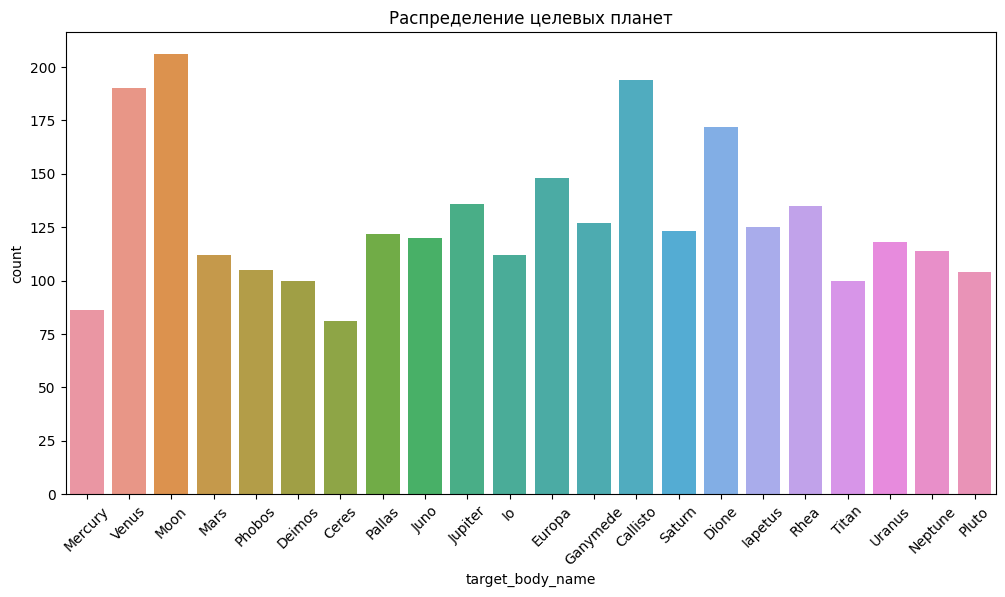

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='target_body_name')
plt.xticks(rotation=45)
plt.title("Распределение целевых планет")
plot_path = os.path.join(save_dir2, "target_body.png")

# Сохранение графика распределения целевых планет в папку images
plt.savefig(plot_path, dpi=300)
plt.show()

In [ ]:
# Установка максимального количества отображаемых столбцов для удобства
pd.set_option('display.max_columns', None)
print(data.describe())

        tof_days_d  delta_v_km_s  r1_total_corrected_x_km  \
count  2830.000000   2830.000000             2.830000e+03   
mean    724.643461     21.368632             1.663001e+07   
std     546.183492      9.842427             1.126001e+08   
min       9.096109     10.908046            -1.497942e+08   
25%     236.119124     14.789303            -7.673179e+07   
50%     728.076334     17.452983            -2.758339e+07   
75%    1007.130737     24.592151             1.369736e+08   
max    2486.533514     49.635381             1.499427e+08   

       r1_total_corrected_y_km  r1_total_corrected_z_km  v1_transfer_x_km_s  \
count             2.830000e+03             2.830000e+03         2830.000000   
mean             -3.318590e+07            -1.436206e+07            8.132333   
std               8.330991e+07             3.611334e+07           22.066673   
min              -1.393499e+08            -6.038166e+07          -33.679801   
25%              -1.144614e+08            -4.958951e+07

In [ ]:
# Конвертация дат в формат datetime
data['launch_date_YYYY-MM-DD'] = pd.to_datetime(data['launch_date_YYYY-MM-DD'])

# Установка эталонной даты для расчёта дней до старта
reference_date = datetime(2025, 1, 1)

data['days_to_launch'] = (data['launch_date_YYYY-MM-DD'] - reference_date).dt.days
# Удаляем исходную дату, так как она не используется напрямую
data = data.drop(columns=['launch_date_YYYY-MM-DD'])

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target_body_name         2830 non-null   object 
 1   tof_days_d               2830 non-null   float64
 2   delta_v_km_s             2830 non-null   float64
 3   r1_total_corrected_x_km  2830 non-null   float64
 4   r1_total_corrected_y_km  2830 non-null   float64
 5   r1_total_corrected_z_km  2830 non-null   float64
 6   v1_transfer_x_km_s       2830 non-null   float64
 7   v1_transfer_y_km_s       2830 non-null   float64
 8   v1_transfer_z_km_s       2830 non-null   float64
 9   r2_total_corrected_x_km  2830 non-null   float64
 10  r2_total_corrected_y_km  2830 non-null   float64
 11  r2_total_corrected_z_km  2830 non-null   float64
 12  v2_transfer_x_km_s       2830 non-null   float64
 13  v2_transfer_y_km_s       2830 non-null   float64
 14  v2_transfer_z_km_s      

In [7]:
# Фильтруем данные для конкретной планеты
planet_data = data[data['target_body_name'] == 'Phobos']  # Замените 'Mars' на нужную планету

# Выводим описание для этой планеты
print(planet_data.describe())

       tof_days_d  delta_v_km_s  r1_total_corrected_x_km  \
count  105.000000    105.000000             1.050000e+02   
mean   323.528661     14.263732             1.348596e+08   
std     42.106653      0.564494             1.505023e+07   
min    241.055687     12.768597             5.736711e+07   
25%    300.000000     13.867557             1.173733e+08   
50%    320.000000     14.394981             1.417474e+08   
75%    344.708472     14.765182             1.479952e+08   
max    470.763429     14.990290             1.499426e+08   

       r1_total_corrected_y_km  r1_total_corrected_z_km  v1_transfer_x_km_s  \
count             1.050000e+02             1.050000e+02          105.000000   
mean             -2.653665e+07            -1.148729e+07            1.199175   
std               6.522346e+07             2.827667e+07           14.440723   
min              -1.388868e+08            -6.017542e+07          -33.641314   
25%              -6.905634e+07            -2.992109e+07         

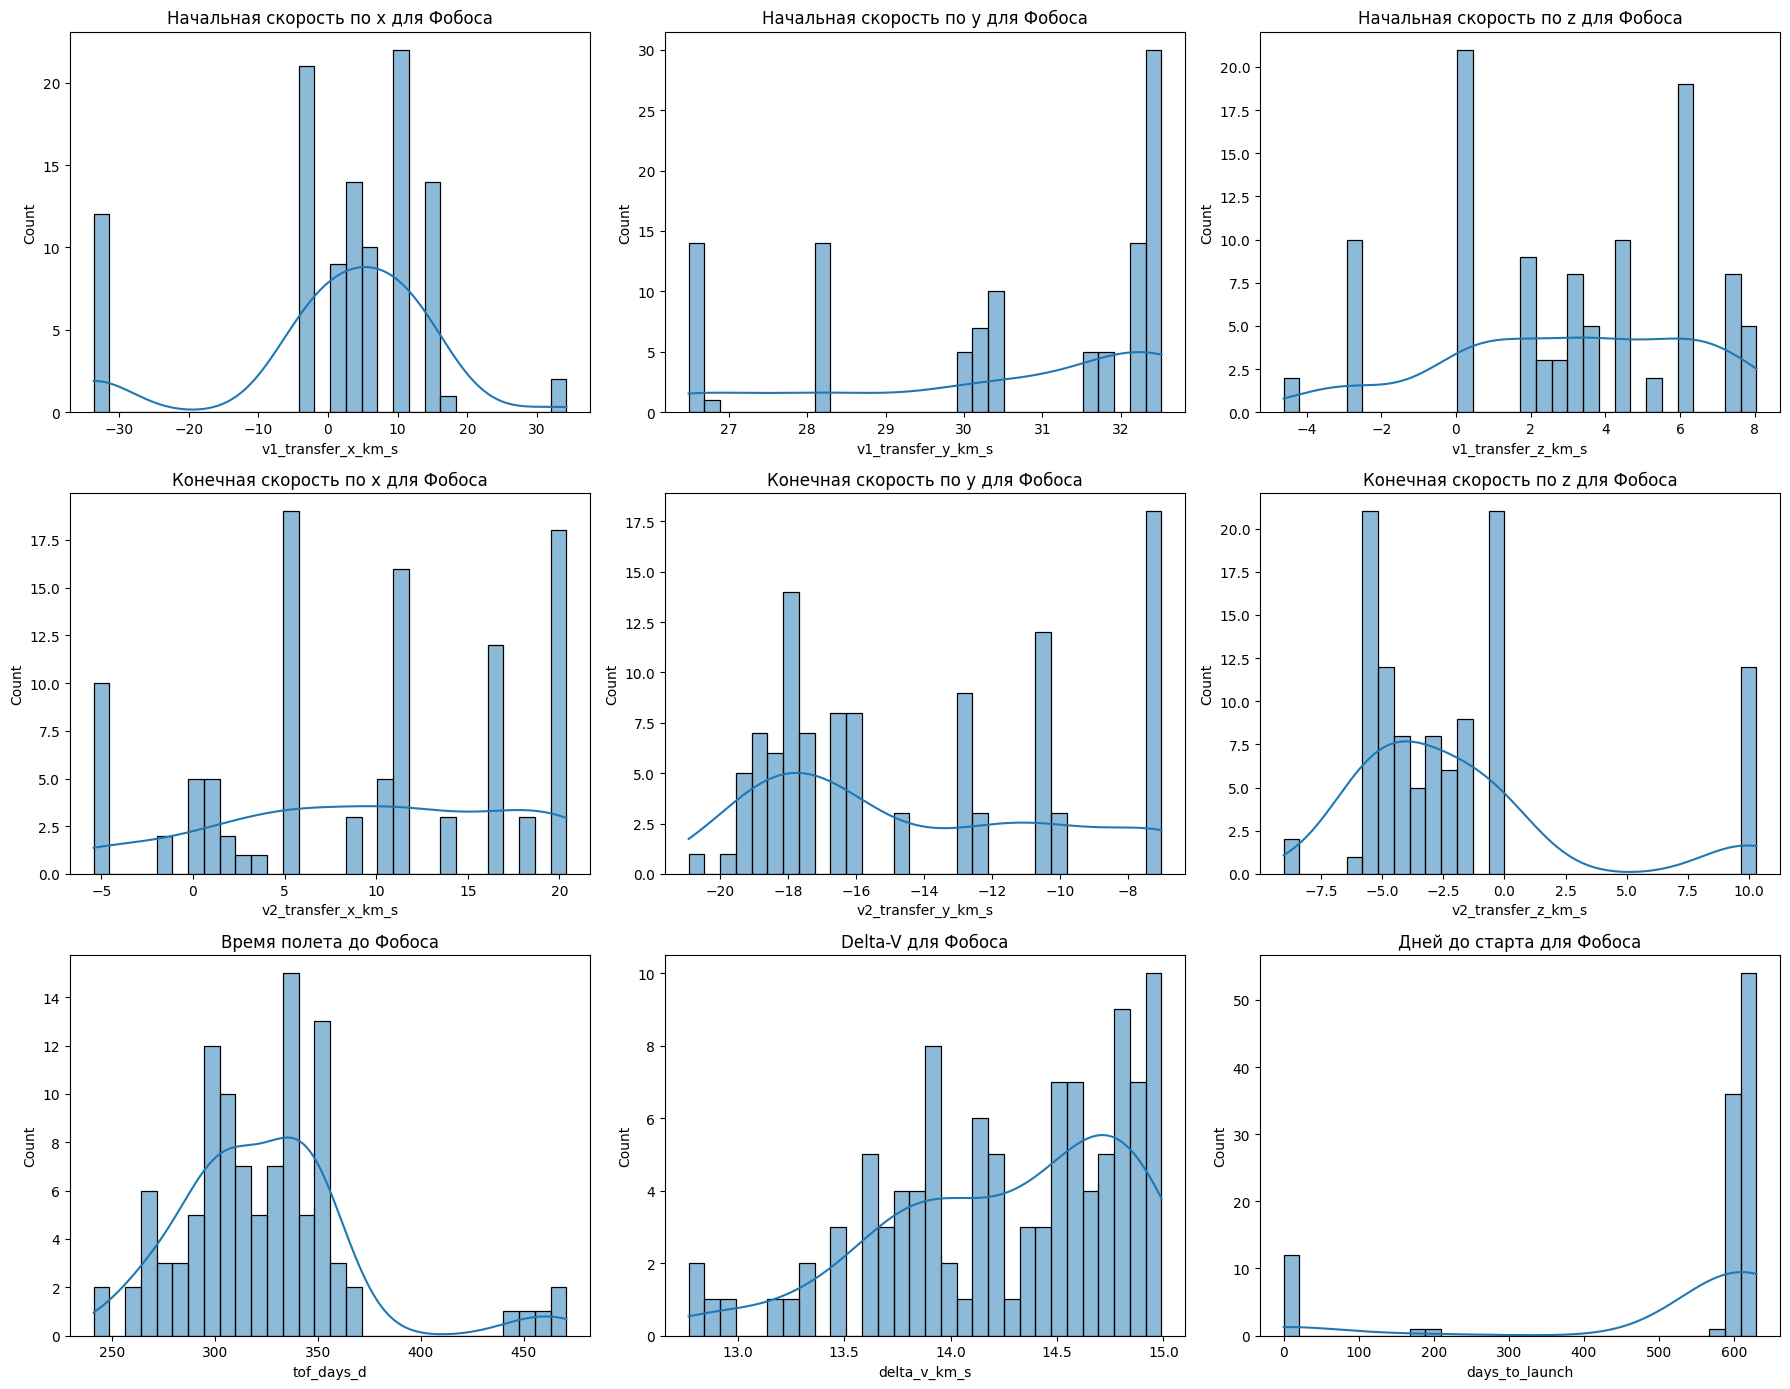

In [ ]:
data_planet = data[data['target_body_name'] == "Phobos"]

plt.figure(figsize=(18, 14))

# Начальная скорость по x
plt.subplot(3, 3, 1)
sns.histplot(data_planet['v1_transfer_x_km_s'], bins=30, kde=True)
plt.title("Начальная скорость по x для Фобоса")

# Начальная скорость по y
plt.subplot(3, 3, 2)
sns.histplot(data_planet['v1_transfer_y_km_s'], bins=30, kde=True)
plt.title("Начальная скорость по y для Фобоса")

# Начальная скорость по z
plt.subplot(3, 3, 3)
sns.histplot(data_planet['v1_transfer_z_km_s'], bins=30, kde=True)
plt.title("Начальная скорость по z для Фобоса")

# Конечная скорость по x
plt.subplot(3, 3, 4)
sns.histplot(data_planet['v2_transfer_x_km_s'], bins=30, kde=True)
plt.title("Конечная скорость по x для Фобоса")

# Конечная скорость по y
plt.subplot(3, 3, 5)
sns.histplot(data_planet['v2_transfer_y_km_s'], bins=30, kde=True)
plt.title("Конечная скорость по y для Фобоса")

# Конечная скорость по z
plt.subplot(3, 3, 6)
sns.histplot(data_planet['v2_transfer_z_km_s'], bins=30, kde=True)
plt.title("Конечная скорость по z для Фобоса")

# Время полета
plt.subplot(3, 3, 7)
sns.histplot(data_planet['tof_days_d'], bins=30, kde=True)
plt.title("Время полета до Фобоса")

# Delta-V
plt.subplot(3, 3, 8)
sns.histplot(data_planet['delta_v_km_s'], bins=30, kde=True)
plt.title("Delta-V для Фобоса")

plt.subplot(3, 3, 9)
sns.histplot(data_planet['days_to_launch'], bins=30, kde=True)
plt.title("Дней до старта для Фобоса")

plt.tight_layout()
plot_path2 = os.path.join(save_dir2, "target_params.png")
plt.savefig(plot_path2, dpi=300)
plt.savefig("target_params.png", dpi=300)
plt.show()

<Figure size 1800x1400 with 0 Axes>

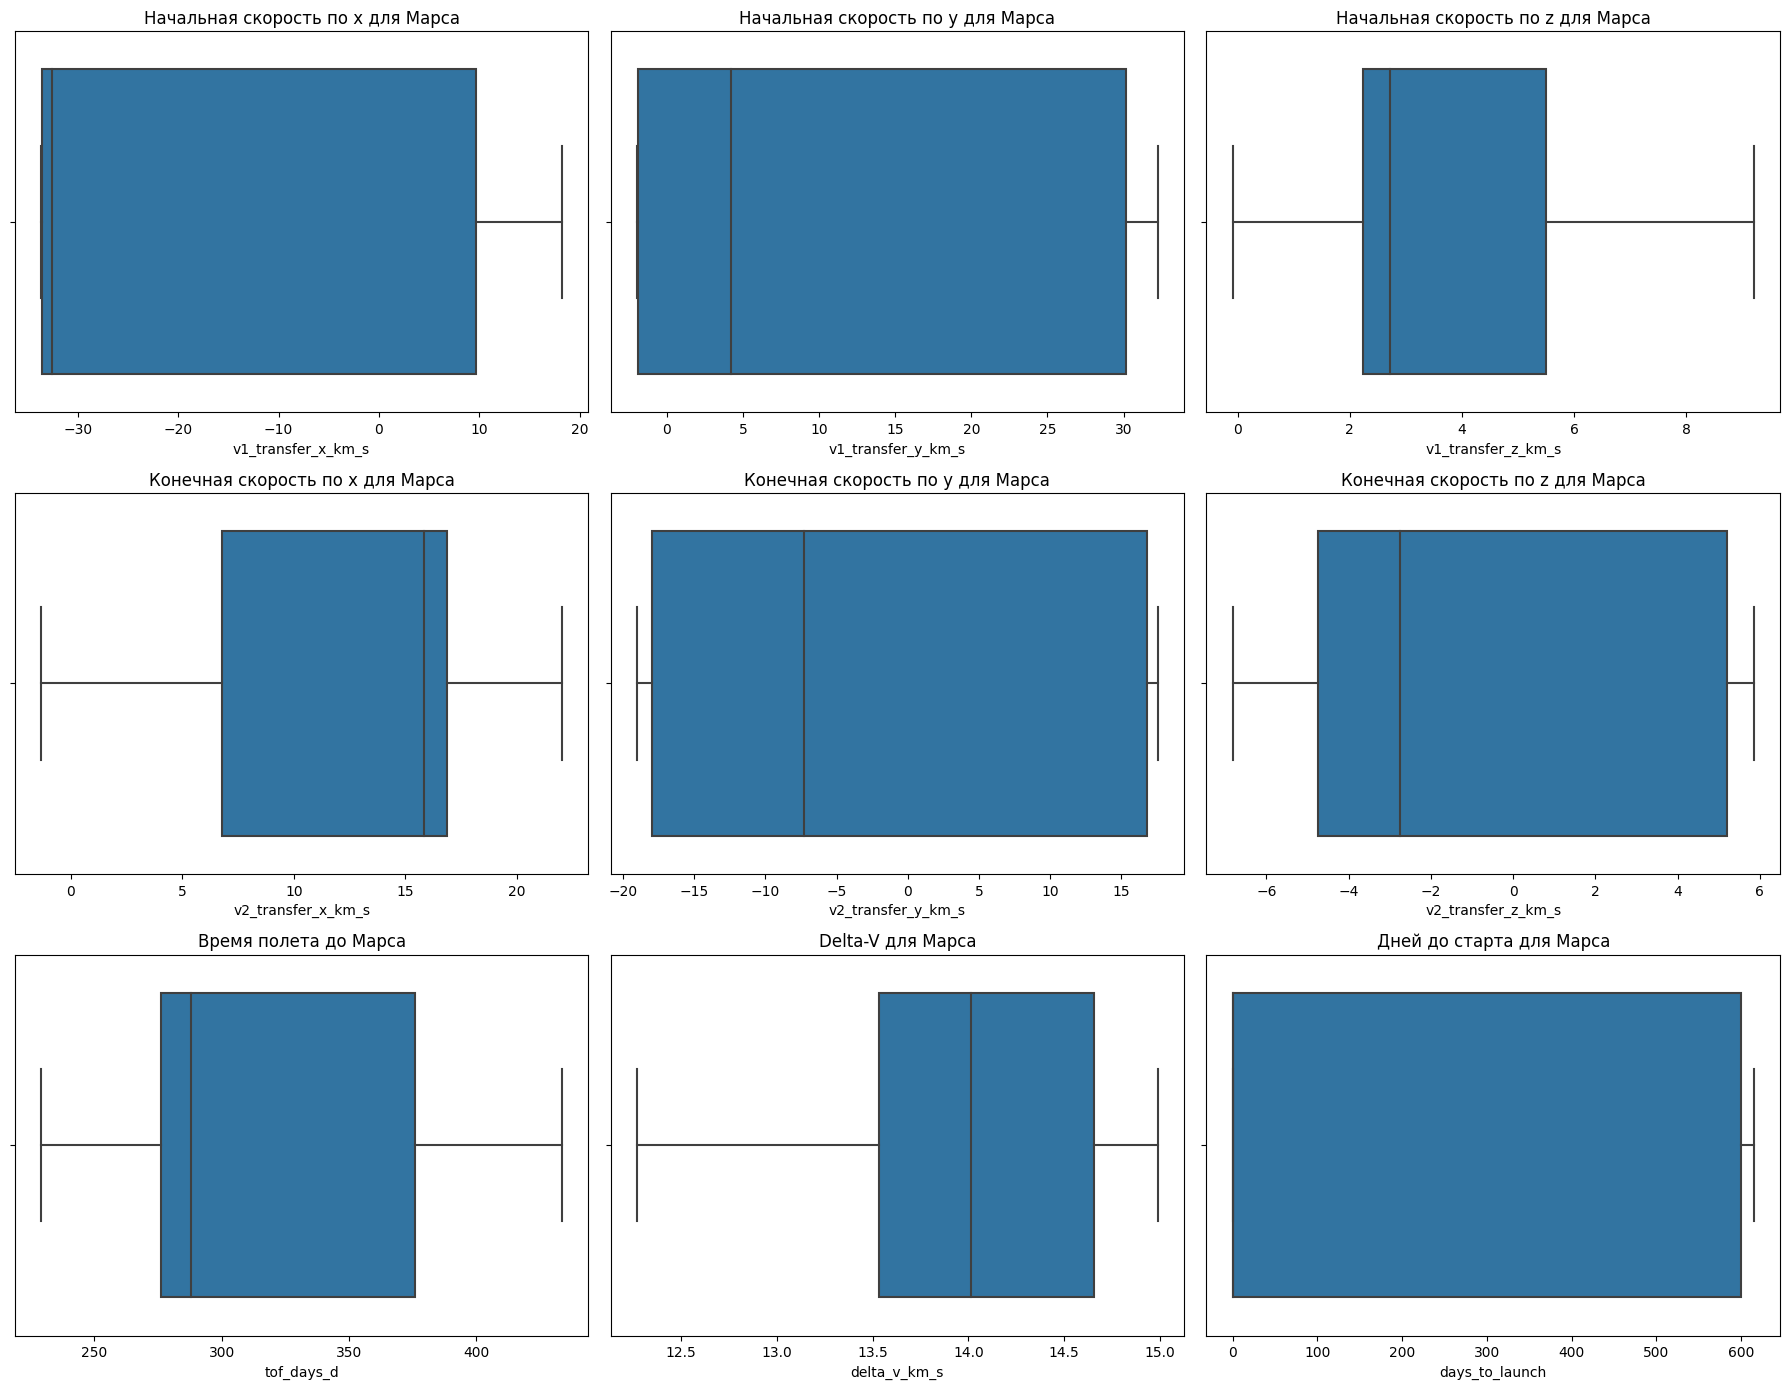

In [ ]:
plt.figure(figsize=(18, 14))
data_planet = data[data['target_body_name'] == "Mars"]
plt.figure(figsize=(18, 14))

# Начальная скорость по x
plt.subplot(3, 3, 1)
sns.boxplot(x=data_planet['v1_transfer_x_km_s'])
plt.title("Начальная скорость по x для Марса")

# Начальная скорость по y
plt.subplot(3, 3, 2)
sns.boxplot(x=data_planet['v1_transfer_y_km_s'])
plt.title("Начальная скорость по y для Марса")

# Начальная скорость по z
plt.subplot(3, 3, 3)
sns.boxplot(x=data_planet['v1_transfer_z_km_s'])
plt.title("Начальная скорость по z для Марса")

# Конечная скорость по x
plt.subplot(3, 3, 4)
sns.boxplot(x=data_planet['v2_transfer_x_km_s'])
plt.title("Конечная скорость по x для Марса")

# Конечная скорость по y
plt.subplot(3, 3, 5)
sns.boxplot(x=data_planet['v2_transfer_y_km_s'])
plt.title("Конечная скорость по y для Марса")

# Конечная скорость по z
plt.subplot(3, 3, 6)
sns.boxplot(x=data_planet['v2_transfer_z_km_s'])
plt.title("Конечная скорость по z для Марса")

# Время полета
plt.subplot(3, 3, 7)
sns.boxplot(x=data_planet['tof_days_d'])
plt.title("Время полета до Марса")

# Delta-V
plt.subplot(3, 3, 8)
sns.boxplot(x=data_planet['delta_v_km_s'])
plt.title("Delta-V для Марса")

plt.subplot(3, 3, 9)
sns.boxplot(x=data_planet['days_to_launch'])
plt.title("Дней до старта для Марса")

plt.tight_layout()
plot_path3 = os.path.join(save_dir2, "target_params2.png")
plt.savefig(plot_path3, dpi=300)
plt.show()

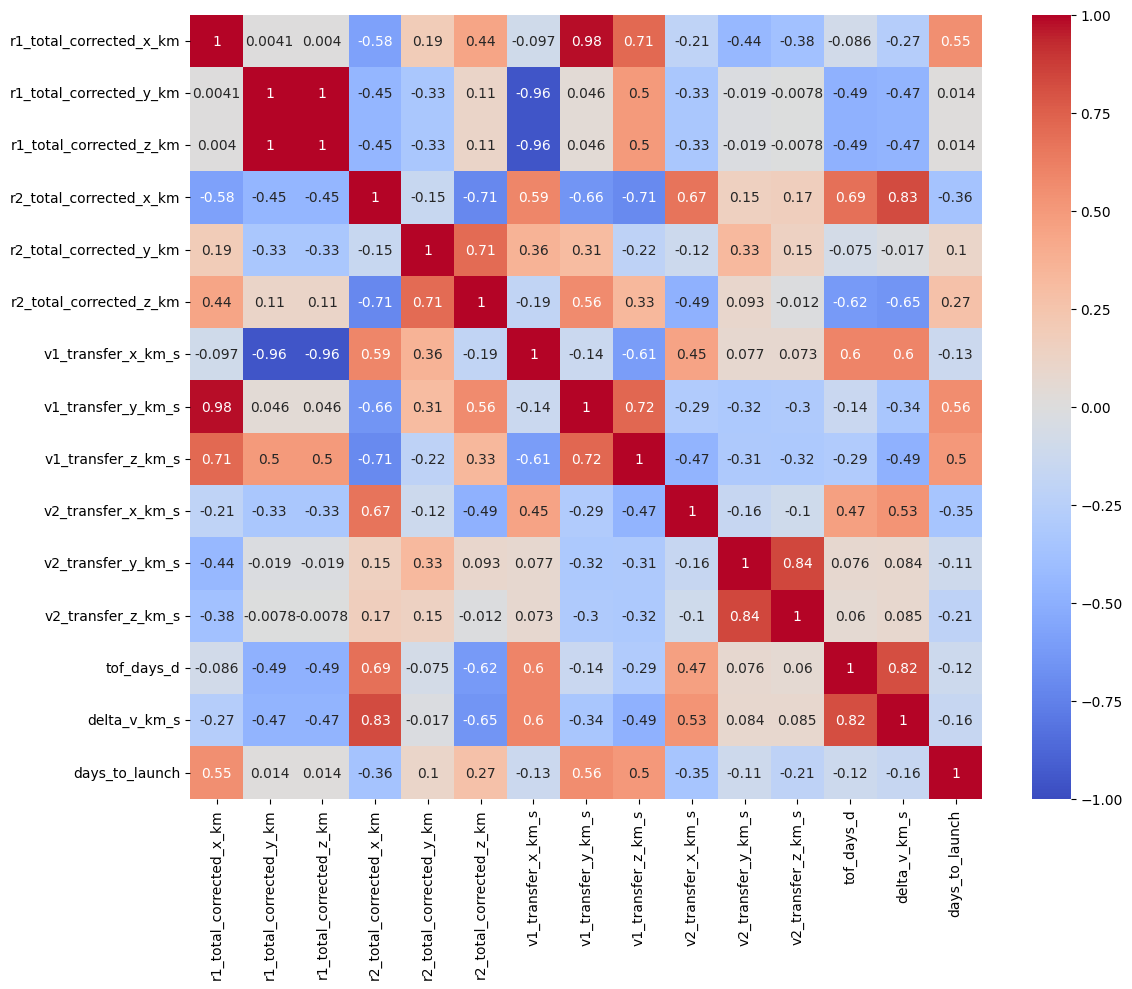

In [ ]:
# Целевые переменные
target_columns = [
    'v1_transfer_x_km_s', 'v1_transfer_y_km_s', 'v1_transfer_z_km_s',
    'v2_transfer_x_km_s', 'v2_transfer_y_km_s', 'v2_transfer_z_km_s',
    'tof_days_d', 'delta_v_km_s', 'days_to_launch'
]

# Получение числовых столбцов из данных
columns = data.select_dtypes(include=[np.number]).columns

# Столбцы, не являющиеся целевыми
non_target_columns = [col for col in columns if col not in target_columns]

# Разбиваем нецелевые столбцы на подгруппы для удобства визуализации
n_cols = 6 # Количество нецелевых столбцов в каждой подгруппе

n_plots = len(non_target_columns) // n_cols + int(len(non_target_columns) % n_cols > 0)

# Построение корреляционных матриц для каждой подгруппы
for i in range(n_plots):
    col_subset = non_target_columns[i * n_cols: (i + 1) * n_cols] + target_columns
    
    correlation_subset = data[col_subset].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.tight_layout()
    plot_path4 = os.path.join(save_dir2, "corr_matrix.png")
    plt.savefig(plot_path4, dpi=300)
    plt.show()

In [ ]:
# Нормализация целевых переменных
scalers = {}
targets_normalized = pd.DataFrame(index=data.index)

for target in target_columns:
    scaler = MinMaxScaler()
    targets_normalized[target] = scaler.fit_transform(data[[target]])
    scalers[target] = scaler

# Удаляем целевые переменные из данных
features = data.drop(columns=target_columns)

# Сохраняем скейлеры для дальнейшего инференса модели
scalers_path = os.path.join(save_dir4, "scalers.pkl")
joblib.dump(scalers, scalers_path)

['scalers.pkl']

In [12]:
print(targets_normalized)
print(scalers)

      v1_transfer_x_km_s  v1_transfer_y_km_s  v1_transfer_z_km_s  \
0               0.538715            0.520888            0.511718   
1               0.538715            0.525344            0.474403   
2               0.538715            0.525344            0.474403   
3               0.538715            0.494034            0.456332   
4               0.538715            0.494034            0.456332   
...                  ...                 ...                 ...   
2825            0.488674            0.000000            0.418501   
2826            0.476738            0.008583            0.416785   
2827            0.475130            0.009733            0.416523   
2828            0.538934            0.017797            0.374551   
2829            0.537325            0.018905            0.374204   

      v2_transfer_x_km_s  v2_transfer_y_km_s  v2_transfer_z_km_s  tof_days_d  \
0               1.000000            0.348284            0.218081    0.039695   
1               0.37226

In [ ]:
# Разделяем данные на обучающую, валидационную и тестовую выборки
X_train_val, X_test, y_train_val, y_test, train_val_targets, test_targets = train_test_split(
    features, targets_normalized, data['target_body_name'], 
    test_size=0.2, random_state=42, stratify=data['target_body_name']
)
X_train, X_val, y_train, y_val, train_targets, val_targets = train_test_split(
    X_train_val, y_train_val, train_val_targets, 
    test_size=0.25, random_state=42, stratify=train_val_targets  # 0.25 * 80% = 20%
)

In [ ]:
# Смотрим как распределились данные
print("Train distribution:")
print(train_targets.value_counts())
print("\nValidation distribution:")
print(val_targets.value_counts())
print("\nTest distribution:")
print(test_targets.value_counts())

Train distribution:
Moon        124
Callisto    116
Venus       114
Dione       104
Europa       89
Jupiter      82
Rhea         81
Ganymede     76
Iapetus      75
Pallas       73
Saturn       73
Juno         72
Uranus       70
Io           68
Neptune      68
Mars         67
Phobos       63
Pluto        62
Deimos       60
Titan        60
Mercury      52
Ceres        49
Name: target_body_name, dtype: int64

Validation distribution:
Moon        41
Callisto    39
Venus       38
Dione       34
Europa      29
Rhea        27
Jupiter     27
Ganymede    26
Iapetus     25
Saturn      25
Uranus      24
Juno        24
Pallas      24
Neptune     23
Mars        23
Io          22
Pluto       21
Phobos      21
Deimos      20
Titan       20
Mercury     17
Ceres       16
Name: target_body_name, dtype: int64

Test distribution:
Moon        41
Callisto    39
Venus       38
Dione       34
Europa      30
Rhea        27
Jupiter     27
Pallas      25
Ganymede    25
Iapetus     25
Saturn      25
Uranus      2

In [ ]:
# Указываем категориальные переменные
categorical_features = ['target_body_name']

In [16]:
# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

2024-11-24 14:08:05,365 - Training model for target: v1_transfer_x_km_s


Training model for target: v1_transfer_x_km_s
0:	learn: 0.2663204	test: 0.2631618	best: 0.2631618 (0)	total: 53ms	remaining: 7m 4s
50:	learn: 0.0503604	test: 0.0531994	best: 0.0531994 (50)	total: 159ms	remaining: 24.8s
100:	learn: 0.0242494	test: 0.0317890	best: 0.0317890 (100)	total: 263ms	remaining: 20.6s
150:	learn: 0.0186299	test: 0.0286602	best: 0.0286602 (150)	total: 365ms	remaining: 19s
200:	learn: 0.0149499	test: 0.0270207	best: 0.0270207 (200)	total: 468ms	remaining: 18.1s
250:	learn: 0.0122253	test: 0.0259570	best: 0.0259570 (250)	total: 571ms	remaining: 17.6s
300:	learn: 0.0104795	test: 0.0254042	best: 0.0254042 (300)	total: 678ms	remaining: 17.3s
350:	learn: 0.0091003	test: 0.0250819	best: 0.0250819 (350)	total: 780ms	remaining: 17s
400:	learn: 0.0081002	test: 0.0247857	best: 0.0247857 (400)	total: 887ms	remaining: 16.8s
450:	learn: 0.0073910	test: 0.0245898	best: 0.0245898 (450)	total: 992ms	remaining: 16.6s
500:	learn: 0.0067676	test: 0.0244357	best: 0.0244357 (500)	total

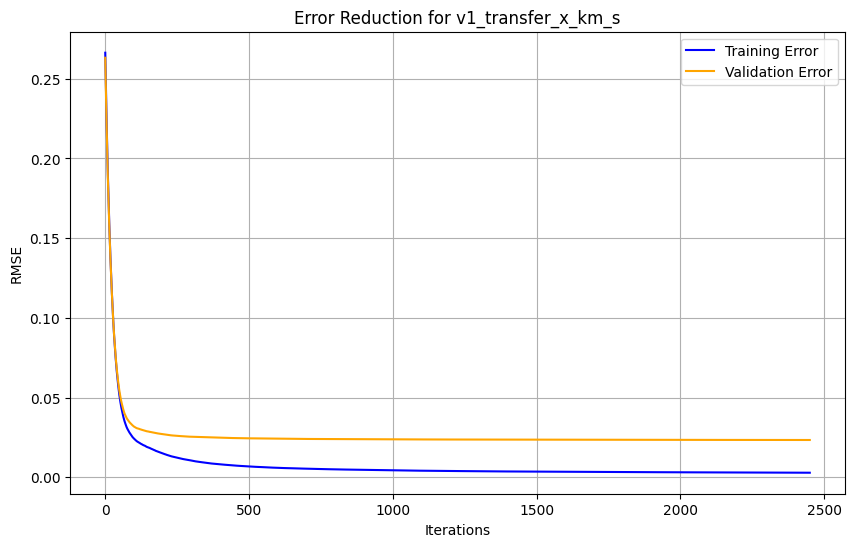

2024-11-24 14:08:11,206 - Model for v1_transfer_x_km_s trained.
2024-11-24 14:08:11,207 - Training model for target: v1_transfer_y_km_s


Training model for target: v1_transfer_y_km_s
0:	learn: 0.2725734	test: 0.2714251	best: 0.2714251 (0)	total: 2.84ms	remaining: 22.7s
50:	learn: 0.0452438	test: 0.0450633	best: 0.0450633 (50)	total: 104ms	remaining: 16.2s
100:	learn: 0.0142319	test: 0.0147152	best: 0.0147152 (100)	total: 209ms	remaining: 16.3s
150:	learn: 0.0097310	test: 0.0105865	best: 0.0105865 (150)	total: 306ms	remaining: 15.9s
200:	learn: 0.0079317	test: 0.0090186	best: 0.0090186 (200)	total: 408ms	remaining: 15.8s
250:	learn: 0.0068740	test: 0.0080354	best: 0.0080354 (250)	total: 507ms	remaining: 15.6s
300:	learn: 0.0059466	test: 0.0071960	best: 0.0071960 (300)	total: 616ms	remaining: 15.8s
350:	learn: 0.0053244	test: 0.0067338	best: 0.0067338 (350)	total: 714ms	remaining: 15.6s
400:	learn: 0.0049298	test: 0.0064388	best: 0.0064388 (400)	total: 818ms	remaining: 15.5s
450:	learn: 0.0045184	test: 0.0060997	best: 0.0060997 (450)	total: 917ms	remaining: 15.3s
500:	learn: 0.0041242	test: 0.0057837	best: 0.0057837 (500)

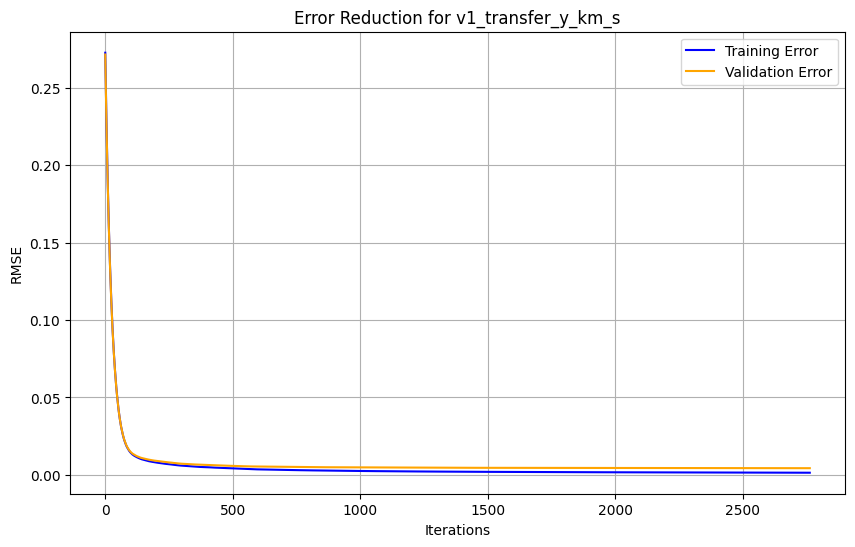

2024-11-24 14:08:17,326 - Model for v1_transfer_y_km_s trained.
2024-11-24 14:08:17,327 - Training model for target: v1_transfer_z_km_s


Training model for target: v1_transfer_z_km_s
0:	learn: 0.2592316	test: 0.2637242	best: 0.2637242 (0)	total: 2.51ms	remaining: 20.1s
50:	learn: 0.0563704	test: 0.0620919	best: 0.0620919 (50)	total: 107ms	remaining: 16.7s
100:	learn: 0.0304138	test: 0.0380605	best: 0.0380605 (100)	total: 217ms	remaining: 16.9s
150:	learn: 0.0240086	test: 0.0329277	best: 0.0329277 (150)	total: 324ms	remaining: 16.9s
200:	learn: 0.0198936	test: 0.0301463	best: 0.0301463 (200)	total: 424ms	remaining: 16.5s
250:	learn: 0.0173440	test: 0.0285068	best: 0.0285068 (250)	total: 526ms	remaining: 16.2s
300:	learn: 0.0153670	test: 0.0273853	best: 0.0273853 (300)	total: 628ms	remaining: 16.1s
350:	learn: 0.0138911	test: 0.0266226	best: 0.0266226 (350)	total: 732ms	remaining: 15.9s
400:	learn: 0.0128067	test: 0.0261412	best: 0.0261412 (400)	total: 832ms	remaining: 15.8s
450:	learn: 0.0119597	test: 0.0256819	best: 0.0256819 (450)	total: 934ms	remaining: 15.6s
500:	learn: 0.0113168	test: 0.0253795	best: 0.0253775 (499)

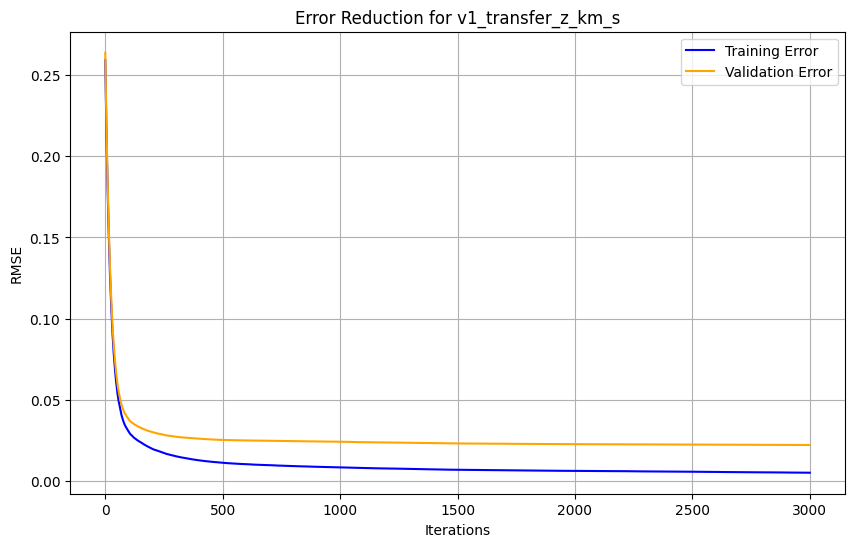

2024-11-24 14:08:24,037 - Model for v1_transfer_z_km_s trained.
2024-11-24 14:08:24,038 - Training model for target: v2_transfer_x_km_s


Training model for target: v2_transfer_x_km_s
0:	learn: 0.1230467	test: 0.1169005	best: 0.1169005 (0)	total: 2.59ms	remaining: 20.8s
50:	learn: 0.0386493	test: 0.0349470	best: 0.0349470 (50)	total: 105ms	remaining: 16.3s
100:	learn: 0.0247113	test: 0.0221573	best: 0.0221573 (100)	total: 207ms	remaining: 16.2s
150:	learn: 0.0201135	test: 0.0182533	best: 0.0182533 (150)	total: 306ms	remaining: 15.9s
200:	learn: 0.0174442	test: 0.0161240	best: 0.0161240 (200)	total: 409ms	remaining: 15.9s
250:	learn: 0.0155732	test: 0.0145342	best: 0.0145342 (250)	total: 506ms	remaining: 15.6s
300:	learn: 0.0139092	test: 0.0132452	best: 0.0132452 (300)	total: 604ms	remaining: 15.5s
350:	learn: 0.0123689	test: 0.0120720	best: 0.0120720 (350)	total: 704ms	remaining: 15.3s
400:	learn: 0.0109862	test: 0.0109059	best: 0.0109059 (400)	total: 805ms	remaining: 15.3s
450:	learn: 0.0098701	test: 0.0102542	best: 0.0102542 (450)	total: 904ms	remaining: 15.1s
500:	learn: 0.0088392	test: 0.0096779	best: 0.0096779 (500)

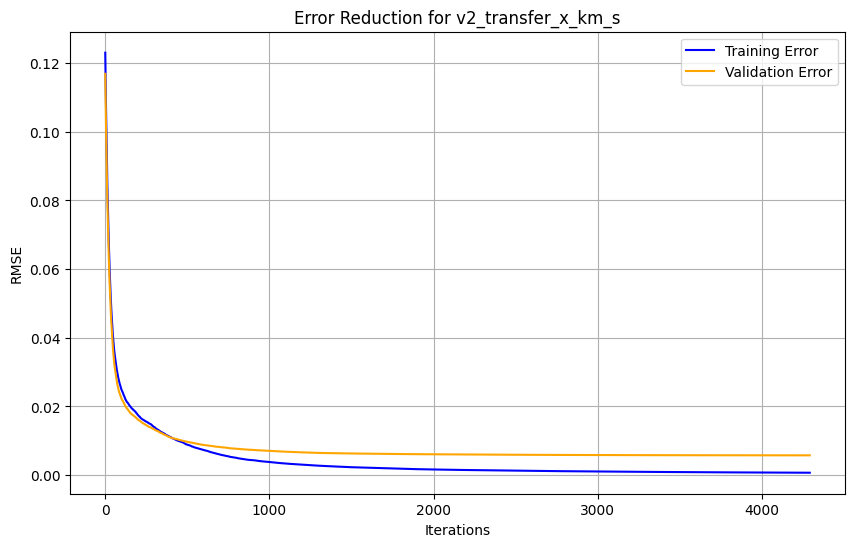

2024-11-24 14:08:33,273 - Model for v2_transfer_x_km_s trained.
2024-11-24 14:08:33,274 - Training model for target: v2_transfer_y_km_s


Training model for target: v2_transfer_y_km_s
0:	learn: 0.1791086	test: 0.1785907	best: 0.1785907 (0)	total: 2.77ms	remaining: 22.2s
50:	learn: 0.0338805	test: 0.0360069	best: 0.0360069 (50)	total: 103ms	remaining: 16.1s
100:	learn: 0.0135431	test: 0.0178920	best: 0.0178920 (100)	total: 203ms	remaining: 15.9s
150:	learn: 0.0098376	test: 0.0151026	best: 0.0151026 (150)	total: 291ms	remaining: 15.1s
200:	learn: 0.0079036	test: 0.0138513	best: 0.0138513 (200)	total: 377ms	remaining: 14.6s
250:	learn: 0.0066064	test: 0.0130587	best: 0.0130587 (250)	total: 473ms	remaining: 14.6s
300:	learn: 0.0057136	test: 0.0126338	best: 0.0126338 (300)	total: 570ms	remaining: 14.6s
350:	learn: 0.0050011	test: 0.0122279	best: 0.0122279 (350)	total: 669ms	remaining: 14.6s
400:	learn: 0.0044253	test: 0.0120010	best: 0.0120010 (400)	total: 768ms	remaining: 14.6s
450:	learn: 0.0039569	test: 0.0118111	best: 0.0118111 (450)	total: 869ms	remaining: 14.5s
500:	learn: 0.0035989	test: 0.0116792	best: 0.0116792 (500)

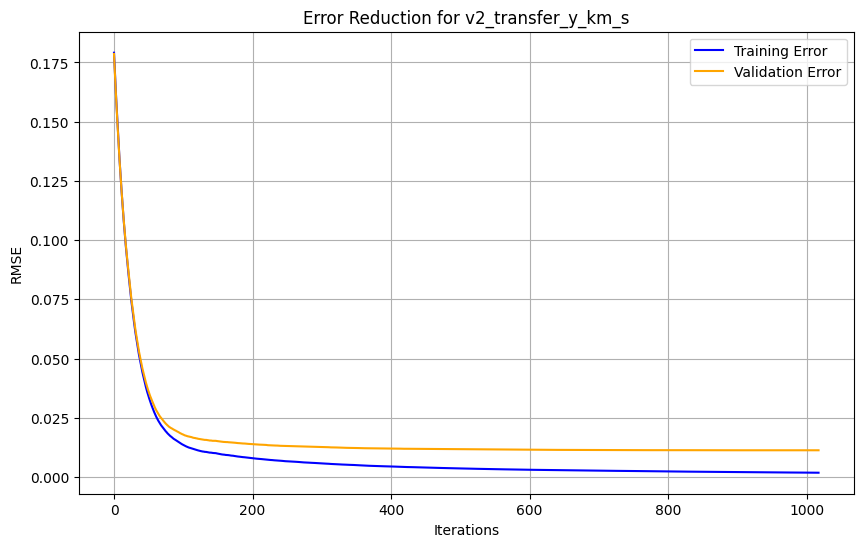

2024-11-24 14:08:35,615 - Model for v2_transfer_y_km_s trained.
2024-11-24 14:08:35,616 - Training model for target: v2_transfer_z_km_s


Training model for target: v2_transfer_z_km_s
0:	learn: 0.1243601	test: 0.1204940	best: 0.1204940 (0)	total: 2.29ms	remaining: 18.3s
50:	learn: 0.0296378	test: 0.0317504	best: 0.0317504 (50)	total: 104ms	remaining: 16.3s
100:	learn: 0.0144983	test: 0.0164641	best: 0.0164641 (100)	total: 206ms	remaining: 16.1s
150:	learn: 0.0106392	test: 0.0125326	best: 0.0125326 (150)	total: 306ms	remaining: 15.9s
200:	learn: 0.0086952	test: 0.0108791	best: 0.0108791 (200)	total: 407ms	remaining: 15.8s
250:	learn: 0.0074600	test: 0.0101261	best: 0.0101261 (250)	total: 509ms	remaining: 15.7s
300:	learn: 0.0066010	test: 0.0096269	best: 0.0096269 (300)	total: 611ms	remaining: 15.6s
350:	learn: 0.0059191	test: 0.0092178	best: 0.0092178 (350)	total: 712ms	remaining: 15.5s
400:	learn: 0.0053732	test: 0.0088925	best: 0.0088925 (400)	total: 817ms	remaining: 15.5s
450:	learn: 0.0048299	test: 0.0085560	best: 0.0085560 (450)	total: 916ms	remaining: 15.3s
500:	learn: 0.0043960	test: 0.0083349	best: 0.0083348 (499)

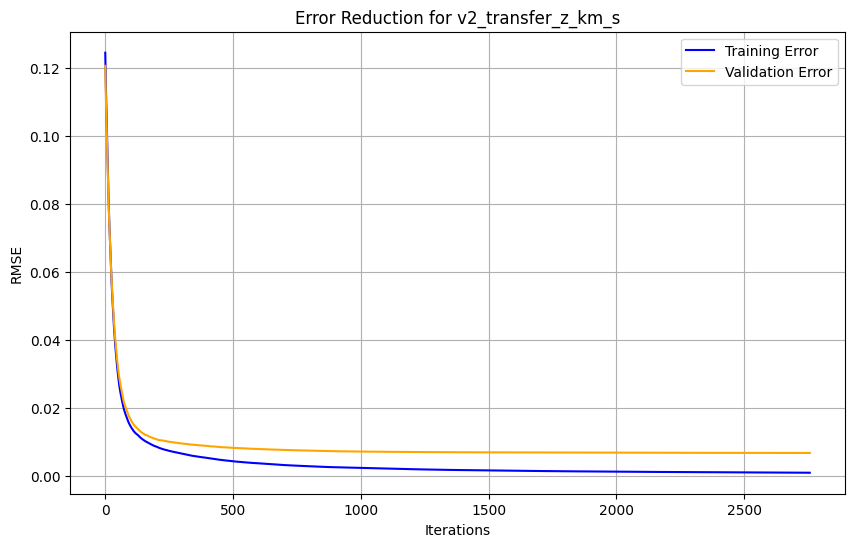

2024-11-24 14:08:41,566 - Model for v2_transfer_z_km_s trained.
2024-11-24 14:08:41,567 - Training model for target: tof_days_d


Training model for target: tof_days_d
0:	learn: 0.2124681	test: 0.2137840	best: 0.2137840 (0)	total: 2.37ms	remaining: 19s
50:	learn: 0.0476794	test: 0.0478404	best: 0.0478404 (50)	total: 102ms	remaining: 15.9s
100:	learn: 0.0271925	test: 0.0286622	best: 0.0286622 (100)	total: 202ms	remaining: 15.8s
150:	learn: 0.0236187	test: 0.0257739	best: 0.0257739 (150)	total: 294ms	remaining: 15.3s
200:	learn: 0.0216379	test: 0.0244395	best: 0.0244395 (200)	total: 393ms	remaining: 15.2s
250:	learn: 0.0202609	test: 0.0235386	best: 0.0235386 (250)	total: 492ms	remaining: 15.2s
300:	learn: 0.0191411	test: 0.0229221	best: 0.0229221 (300)	total: 591ms	remaining: 15.1s
350:	learn: 0.0183588	test: 0.0225823	best: 0.0225823 (350)	total: 688ms	remaining: 15s
400:	learn: 0.0177305	test: 0.0223418	best: 0.0223418 (400)	total: 785ms	remaining: 14.9s
450:	learn: 0.0172121	test: 0.0221859	best: 0.0221859 (450)	total: 889ms	remaining: 14.9s
500:	learn: 0.0167874	test: 0.0220893	best: 0.0220815 (492)	total: 986m

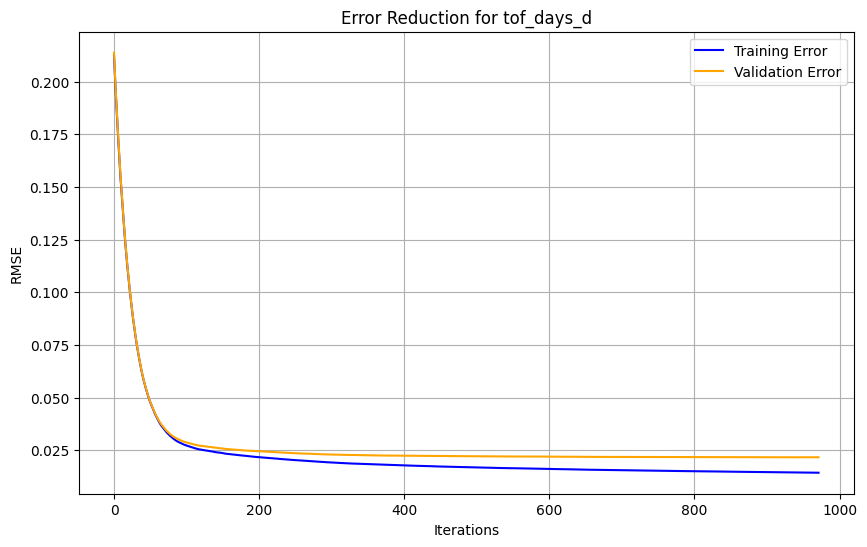

2024-11-24 14:08:43,743 - Model for tof_days_d trained.
2024-11-24 14:08:43,744 - Training model for target: delta_v_km_s


Training model for target: delta_v_km_s
0:	learn: 0.2442818	test: 0.2450499	best: 0.2450499 (0)	total: 2.43ms	remaining: 19.4s
50:	learn: 0.0626634	test: 0.0655183	best: 0.0655183 (50)	total: 102ms	remaining: 15.8s
100:	learn: 0.0361708	test: 0.0389128	best: 0.0389128 (100)	total: 197ms	remaining: 15.4s
150:	learn: 0.0294926	test: 0.0324603	best: 0.0324603 (150)	total: 292ms	remaining: 15.2s
200:	learn: 0.0269227	test: 0.0301903	best: 0.0301903 (200)	total: 388ms	remaining: 15.1s
250:	learn: 0.0253323	test: 0.0288370	best: 0.0288370 (250)	total: 485ms	remaining: 15s
300:	learn: 0.0239778	test: 0.0278225	best: 0.0278225 (300)	total: 586ms	remaining: 15s
350:	learn: 0.0230380	test: 0.0272566	best: 0.0272566 (350)	total: 685ms	remaining: 14.9s
400:	learn: 0.0223221	test: 0.0268548	best: 0.0268548 (400)	total: 783ms	remaining: 14.8s
450:	learn: 0.0216608	test: 0.0265215	best: 0.0265215 (450)	total: 880ms	remaining: 14.7s
500:	learn: 0.0211389	test: 0.0262955	best: 0.0262933 (498)	total: 97

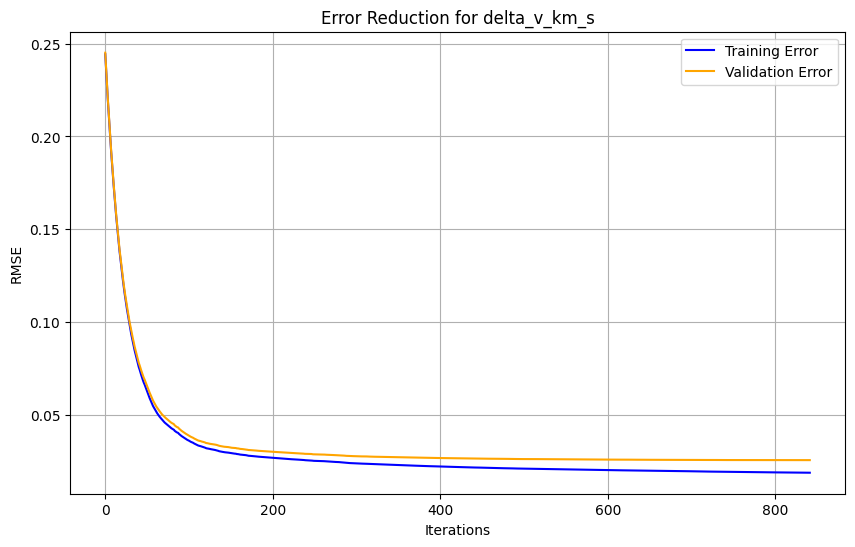

2024-11-24 14:08:45,635 - Model for delta_v_km_s trained.
2024-11-24 14:08:45,636 - Training model for target: days_to_launch


Training model for target: days_to_launch
0:	learn: 0.1590809	test: 0.1652581	best: 0.1652581 (0)	total: 2.42ms	remaining: 19.4s
50:	learn: 0.0567412	test: 0.0632339	best: 0.0632339 (50)	total: 104ms	remaining: 16.3s
100:	learn: 0.0368378	test: 0.0426940	best: 0.0426940 (100)	total: 204ms	remaining: 16s
150:	learn: 0.0283768	test: 0.0347730	best: 0.0347730 (150)	total: 302ms	remaining: 15.7s
200:	learn: 0.0231401	test: 0.0291115	best: 0.0291115 (200)	total: 398ms	remaining: 15.4s
250:	learn: 0.0195688	test: 0.0248446	best: 0.0248446 (250)	total: 494ms	remaining: 15.3s
300:	learn: 0.0176572	test: 0.0216411	best: 0.0216411 (300)	total: 592ms	remaining: 15.1s
350:	learn: 0.0153298	test: 0.0188364	best: 0.0188364 (350)	total: 691ms	remaining: 15.1s
400:	learn: 0.0134716	test: 0.0168013	best: 0.0168013 (400)	total: 792ms	remaining: 15s
450:	learn: 0.0119953	test: 0.0152606	best: 0.0152606 (450)	total: 888ms	remaining: 14.9s
500:	learn: 0.0106240	test: 0.0138349	best: 0.0138349 (500)	total: 

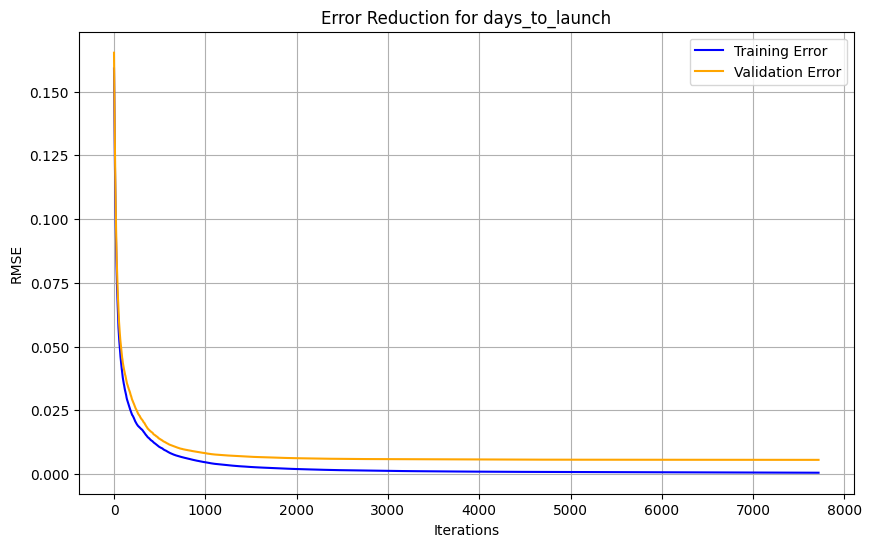

2024-11-24 14:09:01,875 - Model for days_to_launch trained.


In [ ]:
# Создаём модель и настраиваем
models={}
for target in target_columns:
    logger.info(f"Training model for target: {target}")
    print(f"Training model for target: {target}")
    model = CatBoostRegressor(
        iterations=8000,
        depth=7,
        learning_rate=0.04,
        loss_function='RMSE',
        cat_features=categorical_features,
        verbose=50,
        random_seed=42
    )
    model.fit(
        X_train, y_train[target],
        eval_set=(X_val, y_val[target]),
        early_stopping_rounds=50
    )
    # Логи обучения
    train_errors = model.get_evals_result()['learn']['RMSE']
    val_errors = model.get_evals_result()['validation']['RMSE']

    # Визуализируем ошибку
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label='Training Error', color='blue')
    plt.plot(val_errors, label='Validation Error', color='orange')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title(f"Error Reduction for {target}")
    plt.legend()
    plt.grid(True)
    plt.show()
    model_path = os.path.join(save_dir4, f'model_{target}.cbm')
    model.save_model(model_path)
    models[target] = model
    logger.info(f"Model for {target} trained.")

In [18]:
y_pred_denormalized = pd.DataFrame()
y_test_denormalized = pd.DataFrame()

In [ ]:
for target, model in models.items():
    y_pred = model.predict(X_test)
    
    # Денормализуем данные
    y_pred_denormalized[target] = scalers[target].inverse_transform(
        y_pred.reshape(-1, 1)
    ).flatten()
    
    y_test_denormalized[target] = scalers[target].inverse_transform(
        y_test[target].values.reshape(-1, 1)
    ).flatten()

    best_rmse = model.get_best_score()
    
    best_rmse_normalized = model.get_best_score()['validation']['RMSE']
    # Денормализуем RMSE
    std_dev = scalers[target].scale_[0]  # Стандартное отклонение из нормализатора
    best_rmse_denormalized = best_rmse_normalized * std_dev
    
    # MSE (в нормализованном масштабе)
    best_mse_normalized = best_rmse_normalized ** 2
    
    # MSE (в денормализованном масштабе)
    best_mse_denormalized = best_rmse_denormalized ** 2
    
    r2 = r2_score(y_test_denormalized, y_pred_denormalized)
    
        # Вывод метрик
    print(f"VALIDATION metrics Target: {target}")
    print(f" - Normalized RMSE: {best_rmse_normalized}")
    print(f" - Denormalized RMSE: {best_rmse_denormalized}")
    print(f" - Normalized MSE: {best_mse_normalized}")
    print(f" - Denormalized MSE: {best_mse_denormalized}")
    print(f" - Coefficient of Determination (R^2): {r2}\n")
    print("----------------------------------------------")

VALIDATION metrics Target: v1_transfer_x_km_s
 - Normalized RMSE: 0.023388943474472058
 - Denormalized RMSE: 0.0002910045463830299
 - Normalized MSE: 0.0005470426768520491
 - Denormalized MSE: 8.4683646015593e-08
 - Coefficient of Determination (R^2): 0.9994506561890389

----------------------------------------------
VALIDATION metrics Target: v1_transfer_y_km_s
 - Normalized RMSE: 0.004304904887662322
 - Denormalized RMSE: 4.7756832262642234e-05
 - Normalized MSE: 1.853220609181895e-05
 - Denormalized MSE: 2.2807150277621463e-09
 - Coefficient of Determination (R^2): 0.9996450502959295

----------------------------------------------
VALIDATION metrics Target: v1_transfer_z_km_s
 - Normalized RMSE: 0.02225301280434702
 - Denormalized RMSE: 0.0004802070817511135
 - Normalized MSE: 0.0004951965788704323
 - Denormalized MSE: 2.305988413639206e-07
 - Coefficient of Determination (R^2): 0.998660442649229

----------------------------------------------
VALIDATION metrics Target: v2_transfer_

In [20]:
test_metrics_results = {}  # Словарь для хранения всех метрик

for target, model in models.items():
    # Предсказания на тестовом наборе
    y_pred = model.predict(X_test)

    y_pred_denormalized[target] = scalers[target].inverse_transform(
        y_pred.reshape(-1, 1)
    ).flatten()

    y_test_denormalized[target] = scalers[target].inverse_transform(
        y_test[target].values.reshape(-1, 1)
    ).flatten()

    # --- Метрики в денормализованном масштабе ---
    # RMSE
    rmse_denormalized = mean_squared_error(
        y_test_denormalized[target],
        y_pred_denormalized[target],
        squared=False
    )

    # MSE
    mse_denormalized = mean_squared_error(
        y_test_denormalized[target],
        y_pred_denormalized[target],
        squared=True
    )

    # Coefficient of Determination (R^2)
    r2_denormalized = r2_score(
        y_test_denormalized[target],
        y_pred_denormalized[target]
    )

    # --- Метрики в нормализованном масштабе ---
    # RMSE
    rmse_normalized = mean_squared_error(
        y_test[target],
        y_pred,
        squared=False
    )

    # MSE
    mse_normalized = mean_squared_error(
        y_test[target],
        y_pred,
        squared=True
    )

    # Сохраняем результаты
    test_metrics_results[target] = {
        'Denormalized': {
            'RMSE': rmse_denormalized,
            'MSE': mse_denormalized,
            'R^2': r2_denormalized
        },
        'Normalized': {
            'RMSE': rmse_normalized,
            'MSE': mse_normalized
        }
    }

    # Вывод результатов
    print(f"Target: {target}")
    print(" - Denormalized:")
    print(f"   * RMSE: {rmse_denormalized}")
    print(f"   * MSE: {mse_denormalized}")
    print(f"   * Coefficient of Determination (R^2): {r2_denormalized}\n")
    print(" - Normalized:")
    print(f"   * RMSE: {rmse_normalized}")
    print(f"   * MSE: {mse_normalized}")
    print(" -------------------------------------------------------------")

Target: v1_transfer_x_km_s
 - Denormalized:
   * RMSE: 0.5080485046694131
   * MSE: 0.2581132830968267
   * Coefficient of Determination (R^2): 0.9994506561890389

 - Normalized:
   * RMSE: 0.006321124543452101
   * MSE: 3.995661549383253e-05
 -------------------------------------------------------------
Target: v1_transfer_y_km_s
 - Denormalized:
   * RMSE: 0.32792972390606734
   * MSE: 0.10753790382110955
   * Coefficient of Determination (R^2): 0.9998394444028201

 - Normalized:
   * RMSE: 0.0036379165689351418
   * MSE: 1.3234436962532834e-05
 -------------------------------------------------------------
Target: v1_transfer_z_km_s
 - Denormalized:
   * RMSE: 0.7217659344795218
   * MSE: 0.5209460641750973
   * Coefficient of Determination (R^2): 0.9966912273558284

 - Normalized:
   * RMSE: 0.015575289339521271
   * MSE: 0.00024258963800980499
 -------------------------------------------------------------
Target: v2_transfer_x_km_s
 - Denormalized:
   * RMSE: 0.5396761133682707
   

In [21]:
planet_metrics = {}

# Фильтрация данных для конкретной планеты
planet_indices = X_test['target_body_name'] == 'Mars'
X_test_planet = X_test[planet_indices]
y_test_planet = y_test[planet_indices]

# Словари для хранения денормализованных и нормализованных данных
y_test_denormalized_planet = {}
y_pred_denormalized_planet = {}

for target, model in models.items():
    y_pred_planet = model.predict(X_test_planet)

    # Денормализация
    y_pred_denormalized_planet[target] = scalers[target].inverse_transform(
        y_pred_planet.reshape(-1, 1)
    ).flatten()

    y_test_denormalized_planet[target] = scalers[target].inverse_transform(
        y_test_planet[target].values.reshape(-1, 1)
    ).flatten()

    # --- Метрики в денормализованном масштабе ---
    rmse_denormalized = mean_squared_error(
        y_test_denormalized_planet[target],
        y_pred_denormalized_planet[target],
        squared=False
    )
    mse_denormalized = mean_squared_error(
        y_test_denormalized_planet[target],
        y_pred_denormalized_planet[target],
        squared=True
    )
    r2_denormalized = r2_score(
        y_test_denormalized_planet[target],
        y_pred_denormalized_planet[target]
    )

    # --- Метрики в нормализованном масштабе ---
    rmse_normalized = mean_squared_error(
        y_test_planet[target],
        y_pred_planet,
        squared=False
    )
    mse_normalized = mean_squared_error(
        y_test_planet[target],
        y_pred_planet,
        squared=True
    )

    # Сохраняем метрики
    planet_metrics[target] = {
        'Denormalized': {
            'RMSE': rmse_denormalized,
            'MSE': mse_denormalized,
            'R^2': r2_denormalized
        },
        'Normalized': {
            'RMSE': rmse_normalized,
            'MSE': mse_normalized
        }
    }

# Вывод метрик для планеты
print("Metrics for Mars:")
for target, metric_values in planet_metrics.items():
    print(f" - Target: {target}")
    print("   Denormalized:")
    print(f"     RMSE: {metric_values['Denormalized']['RMSE']}")
    print(f"     MSE: {metric_values['Denormalized']['MSE']}")
    print(f"     R^2: {metric_values['Denormalized']['R^2']}\n")
    print("   Normalized:")
    print(f"     RMSE: {metric_values['Normalized']['RMSE']}")
    print(f"     MSE: {metric_values['Normalized']['MSE']}")
    print("-----------------------------------------")

Metrics for Mars:
 - Target: v1_transfer_x_km_s
   Denormalized:
     RMSE: 0.23786902075751545
     MSE: 0.056581671036139314
     R^2: 0.9998682225377532

   Normalized:
     RMSE: 0.0029595593558840202
     MSE: 8.758991581000636e-06
-----------------------------------------
 - Target: v1_transfer_y_km_s
   Denormalized:
     RMSE: 0.15185492582867663
     MSE: 0.023059918498432877
     R^2: 0.9999042769668199

   Normalized:
     RMSE: 0.0016846156675471146
     MSE: 2.8379299473452103e-06
-----------------------------------------
 - Target: v1_transfer_z_km_s
   Denormalized:
     RMSE: 0.26439611754589204
     MSE: 0.06990530697334117
     R^2: 0.9853547560527385

   Normalized:
     RMSE: 0.005705514536361349
     MSE: 3.255289612463066e-05
-----------------------------------------
 - Target: v2_transfer_x_km_s
   Denormalized:
     RMSE: 0.14886795805674466
     MSE: 0.022161668935984685
     R^2: 0.9993962321819589

   Normalized:
     RMSE: 0.0017630938462039683
     MSE: 3.1

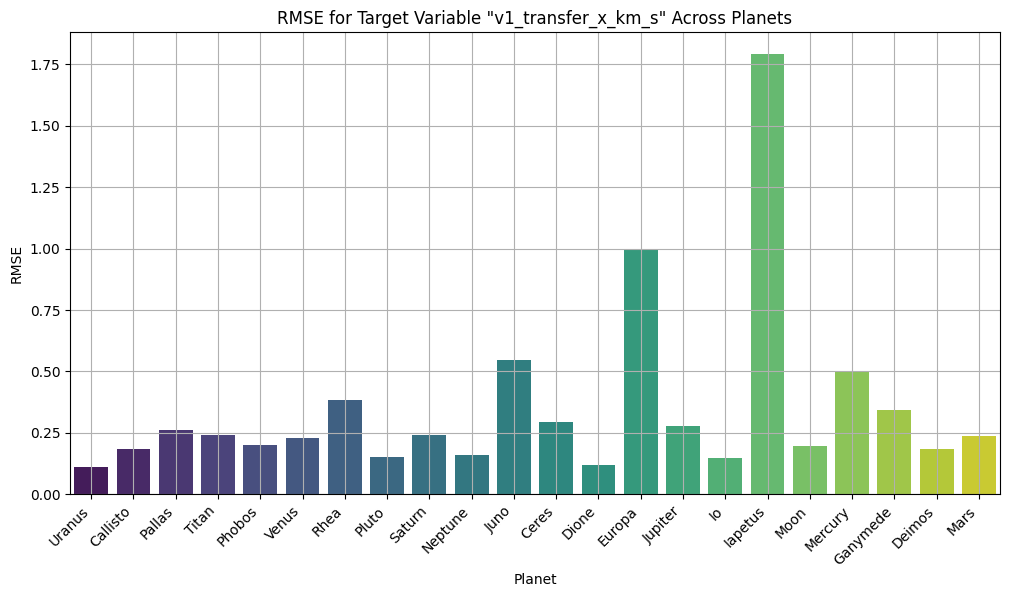

In [ ]:
# Целевая переменная, для которой строится график
selected_target = 'v1_transfer_x_km_s'  # Замените на нужную переменную

# Словарь для хранения RMSE по планетам для выбранной переменной
rmse_by_planet = {}

# Рассчитываем RMSE для каждой планеты
for planet in X_test['target_body_name'].unique():
    # Фильтрация данных для конкретной планеты
    planet_indices = X_test['target_body_name'] == planet
    X_test_planet = X_test[planet_indices]
    y_test_planet = y_test[planet_indices]

    # Предсказания для текущей целевой переменной
    model = models[selected_target]
    y_pred_planet = model.predict(X_test_planet)

    # Денормализация
    y_pred_denormalized = scalers[selected_target].inverse_transform(
        y_pred_planet.reshape(-1, 1)
    ).flatten()
    y_test_denormalized = scalers[selected_target].inverse_transform(
        y_test_planet[selected_target].values.reshape(-1, 1)
    ).flatten()

    # Вычисление RMSE
    rmse = mean_squared_error(
        y_test_denormalized,
        y_pred_denormalized,
        squared=False
    )
    rmse_by_planet[planet] = rmse

# Построение графика RMSE для выбранной переменной по планетам
plt.figure(figsize=(12, 6))
sns.barplot(
    x=list(rmse_by_planet.keys()),
    y=list(rmse_by_planet.values()),
    palette='viridis'
)
plt.xlabel('Planet')
plt.ylabel('RMSE')
plt.title(f'RMSE for Target Variable "{selected_target}" Across Planets')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Сохранение графика
plot_path5 = os.path.join(save_dir2, "RMSE_v1x.png")
plt.savefig(plot_path5, dpi=300)
plt.show()

SHAP analysis for v1_transfer_x_km_s


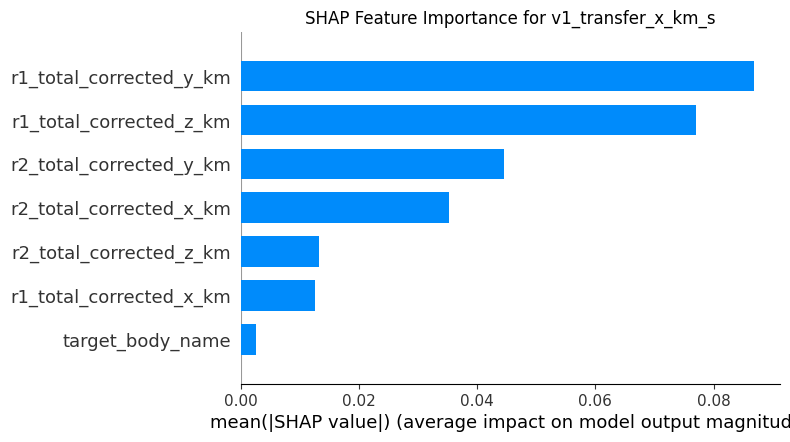

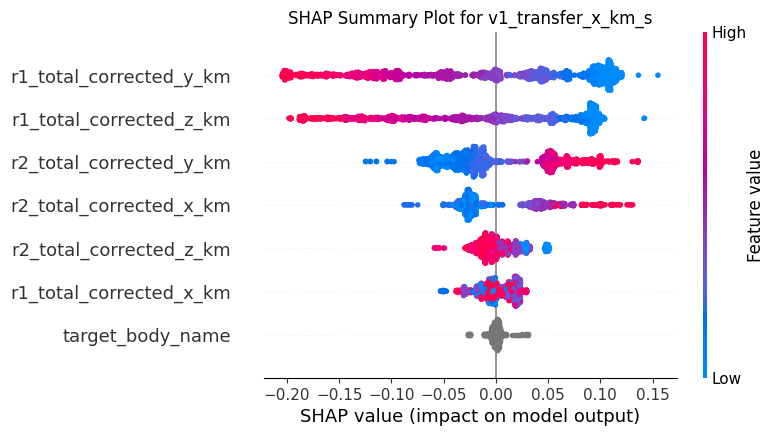

SHAP analysis for v1_transfer_y_km_s


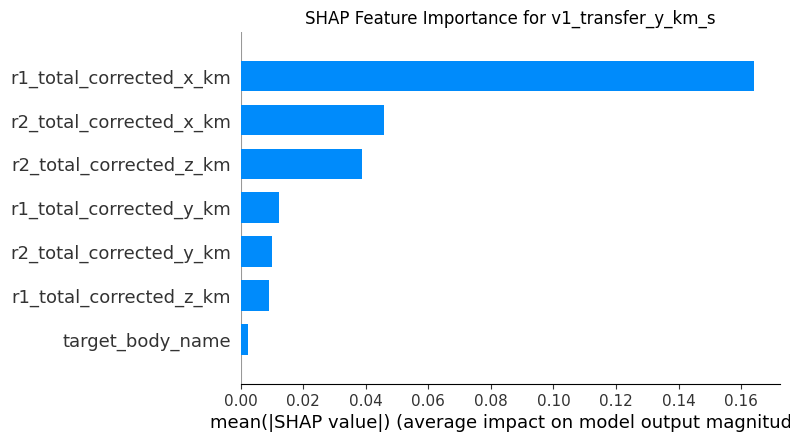

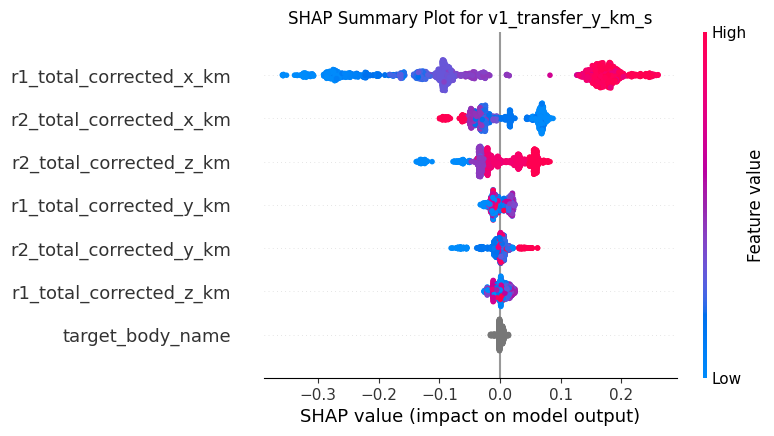

SHAP analysis for v1_transfer_z_km_s


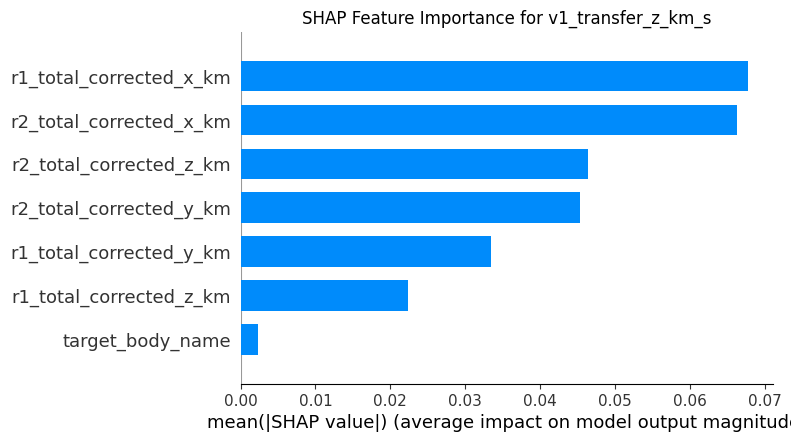

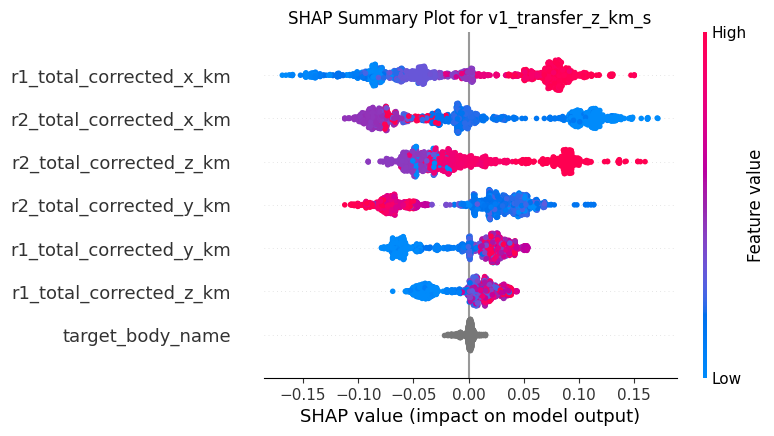

SHAP analysis for v2_transfer_x_km_s


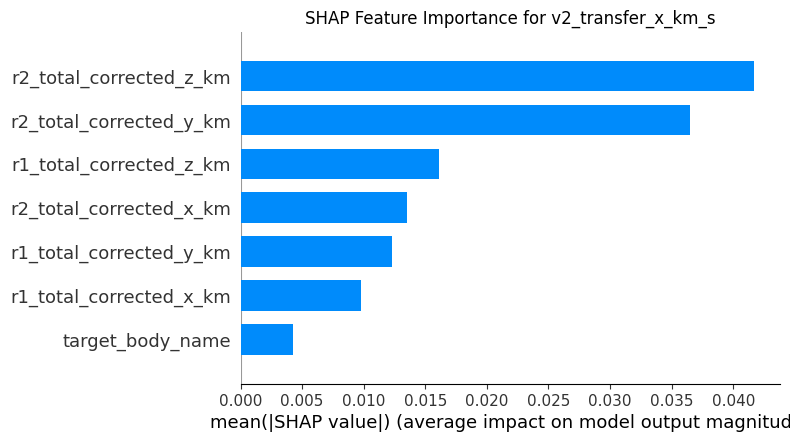

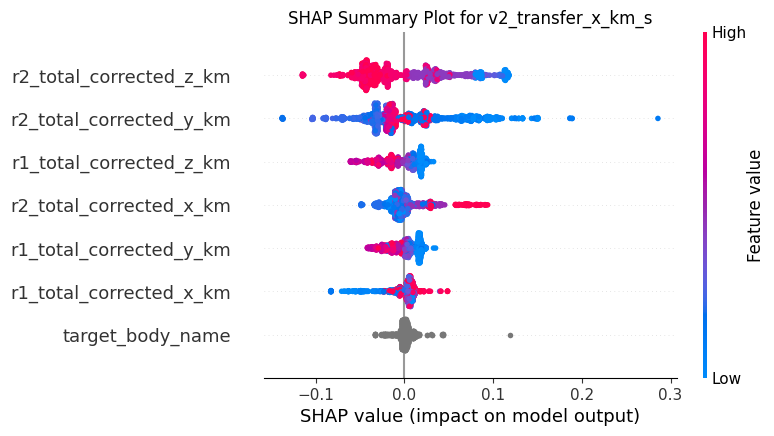

SHAP analysis for v2_transfer_y_km_s


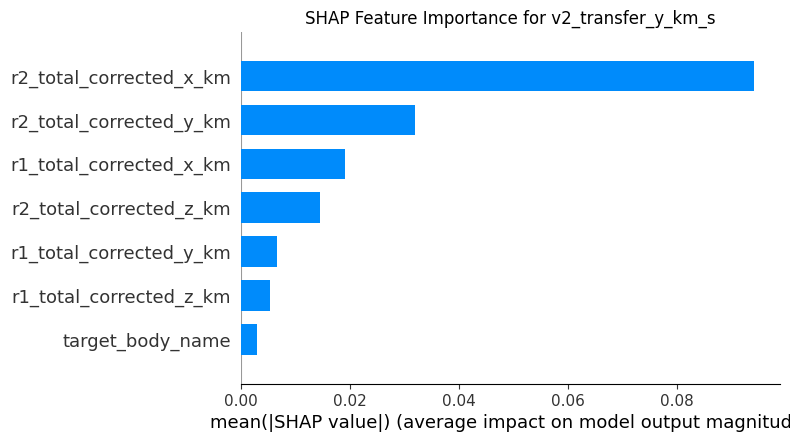

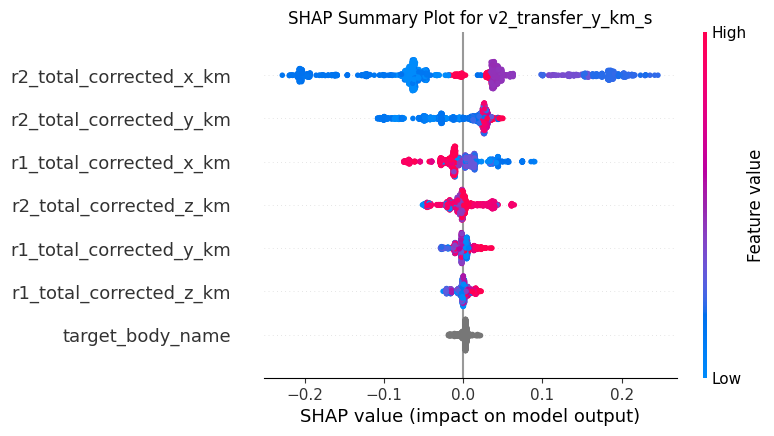

SHAP analysis for v2_transfer_z_km_s


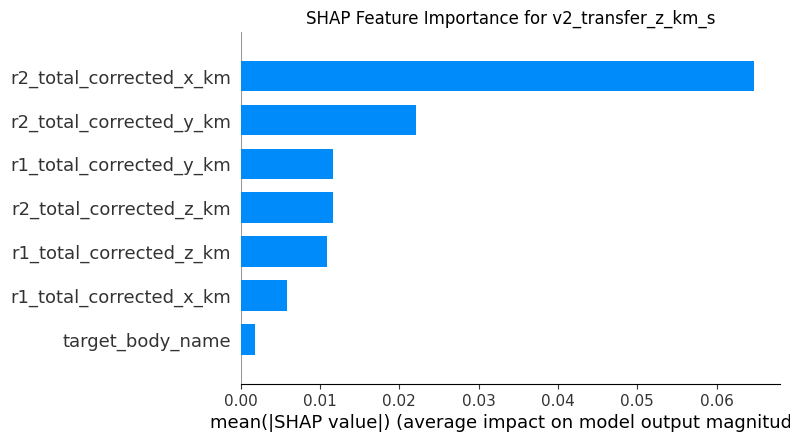

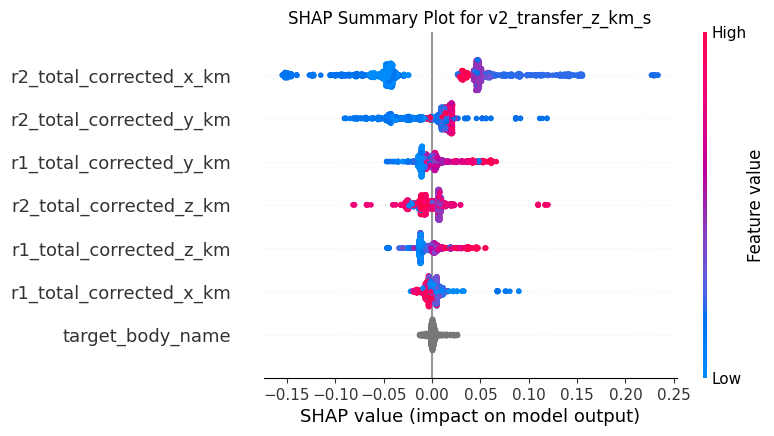

SHAP analysis for tof_days_d


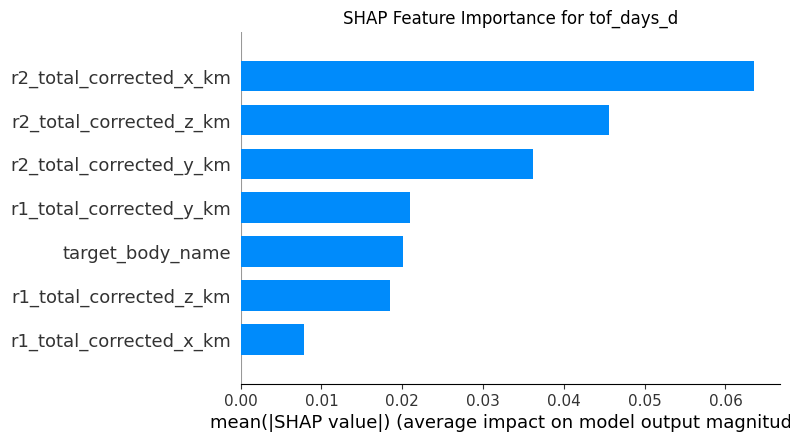

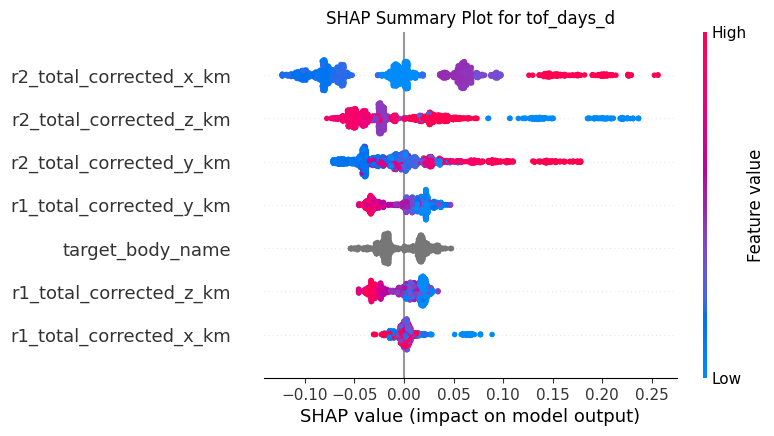

SHAP analysis for delta_v_km_s


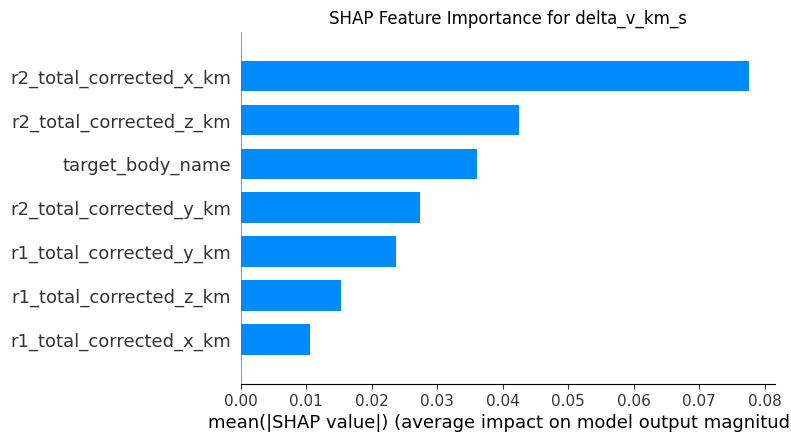

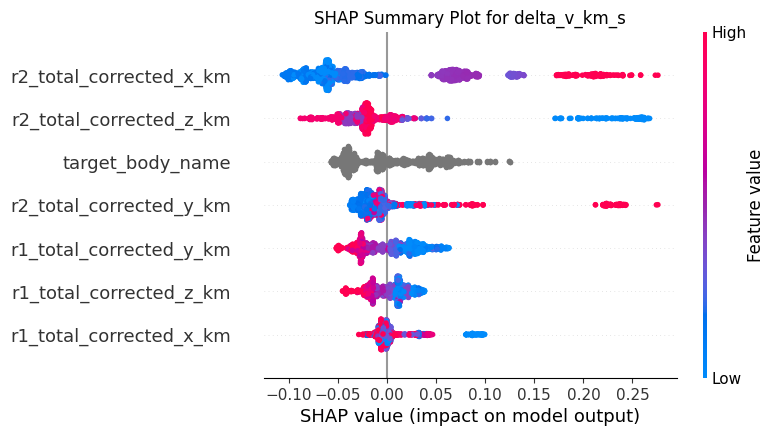

SHAP analysis for days_to_launch


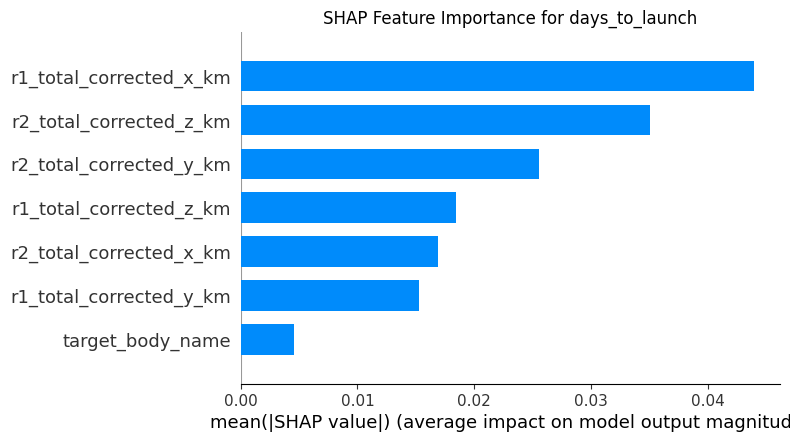

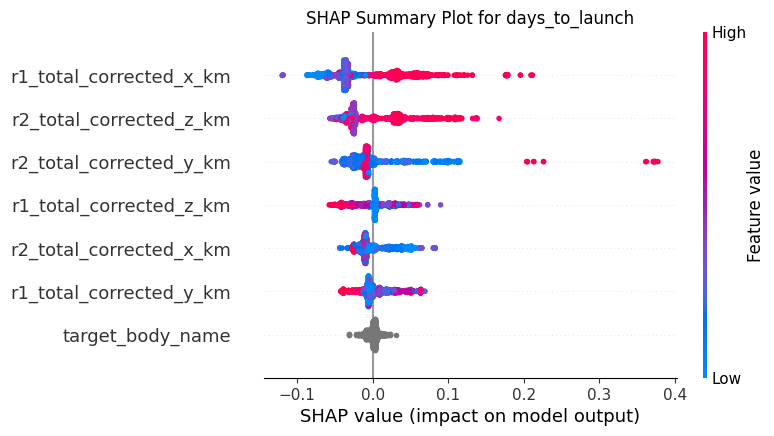

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


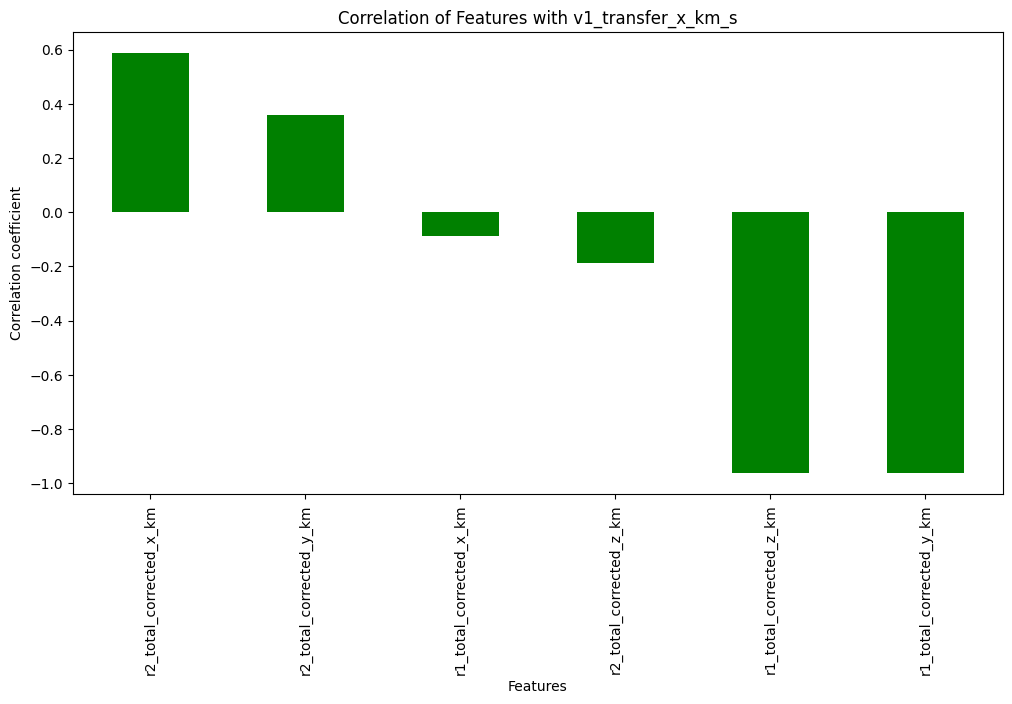

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


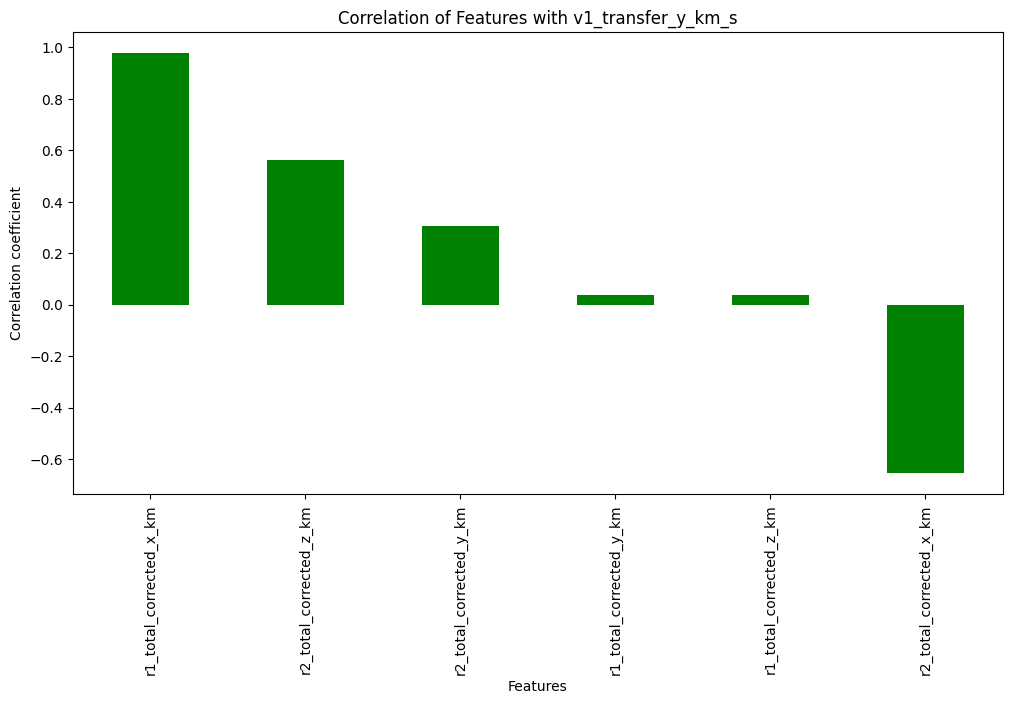

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


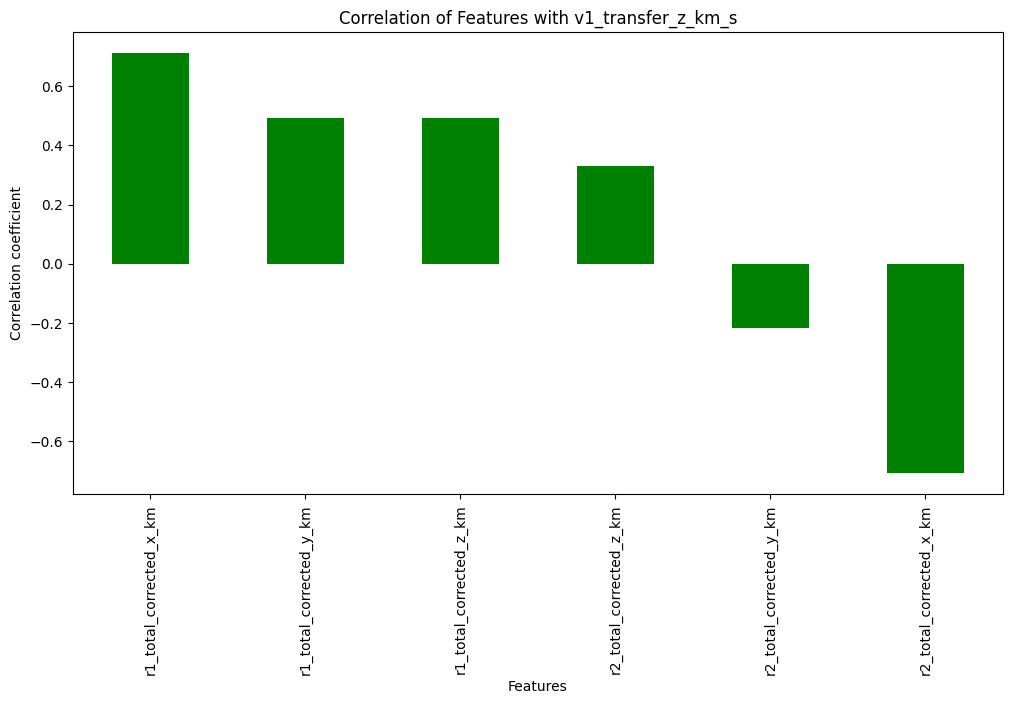

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


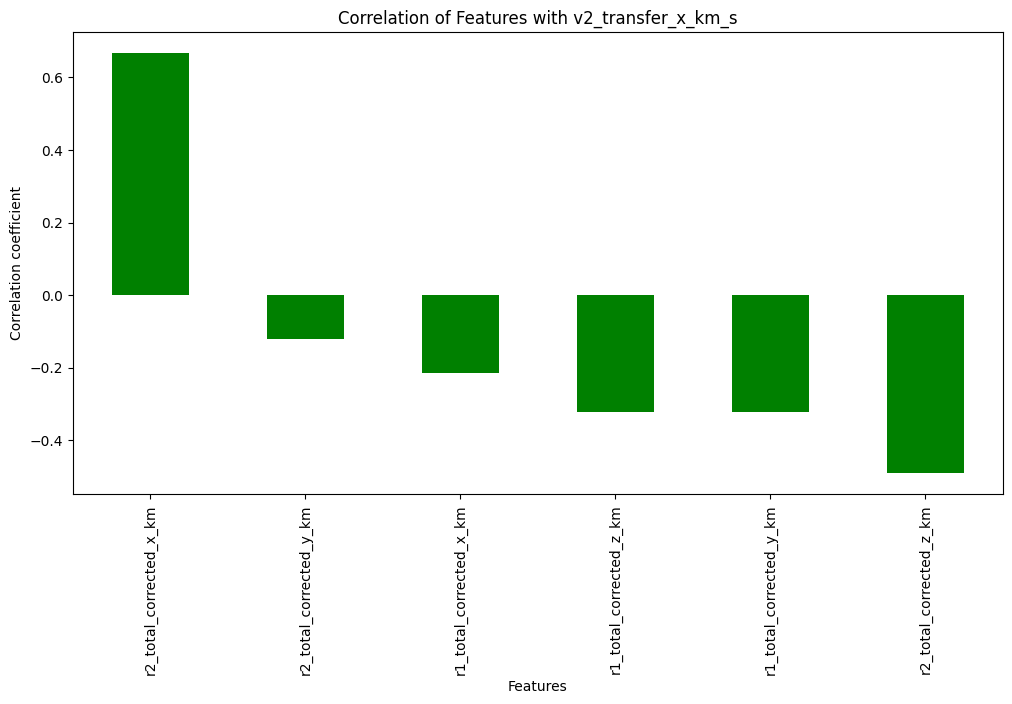

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


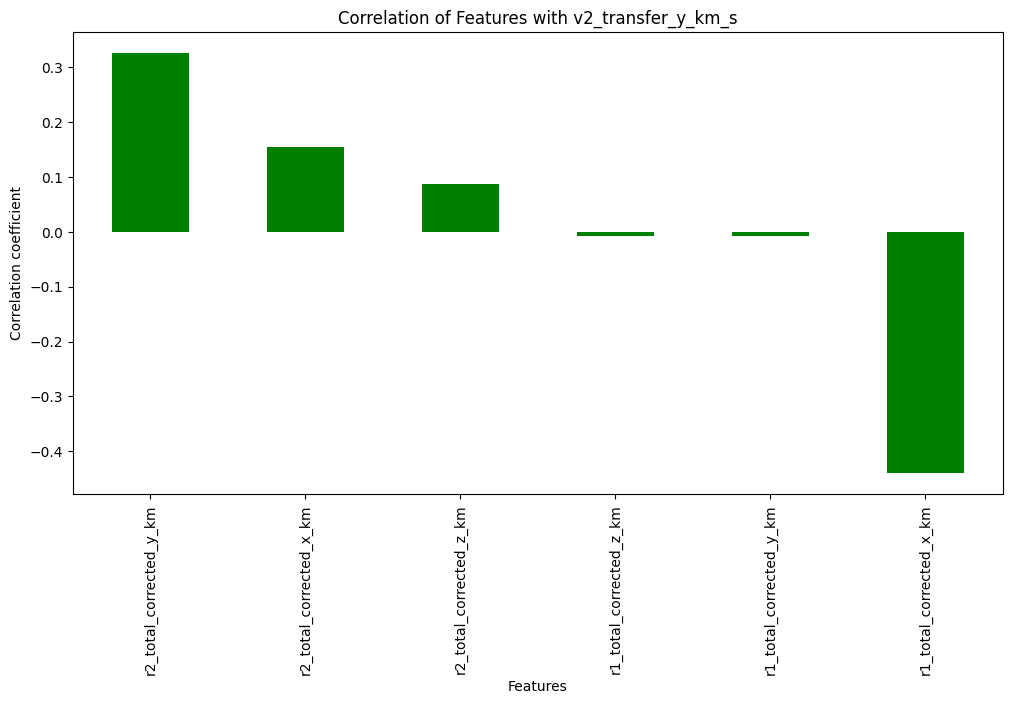

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


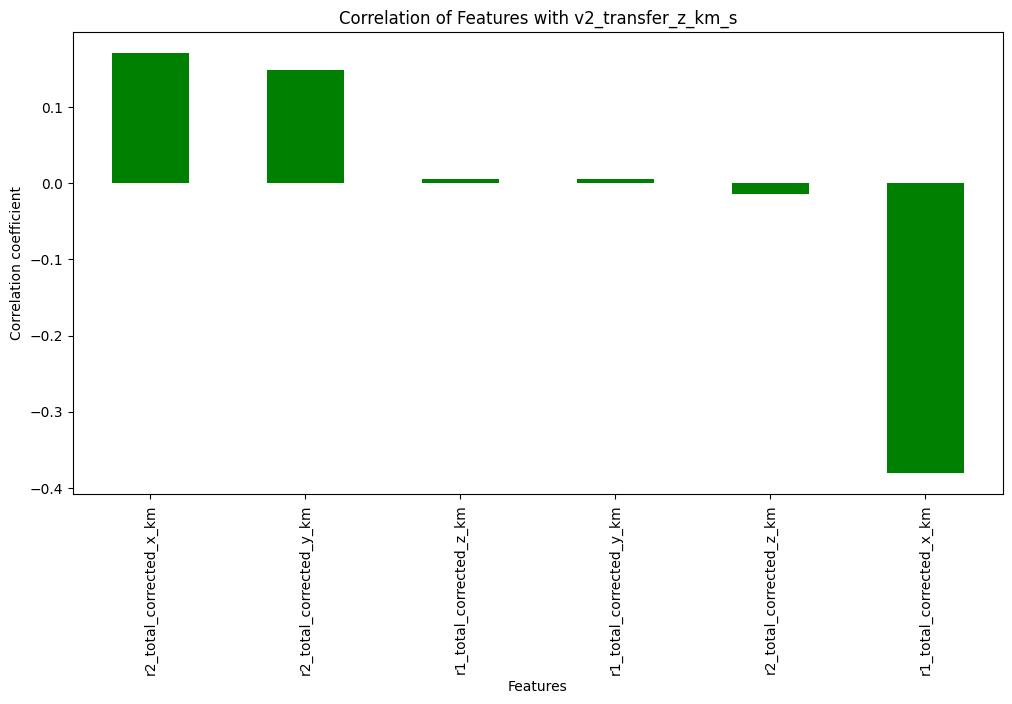

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


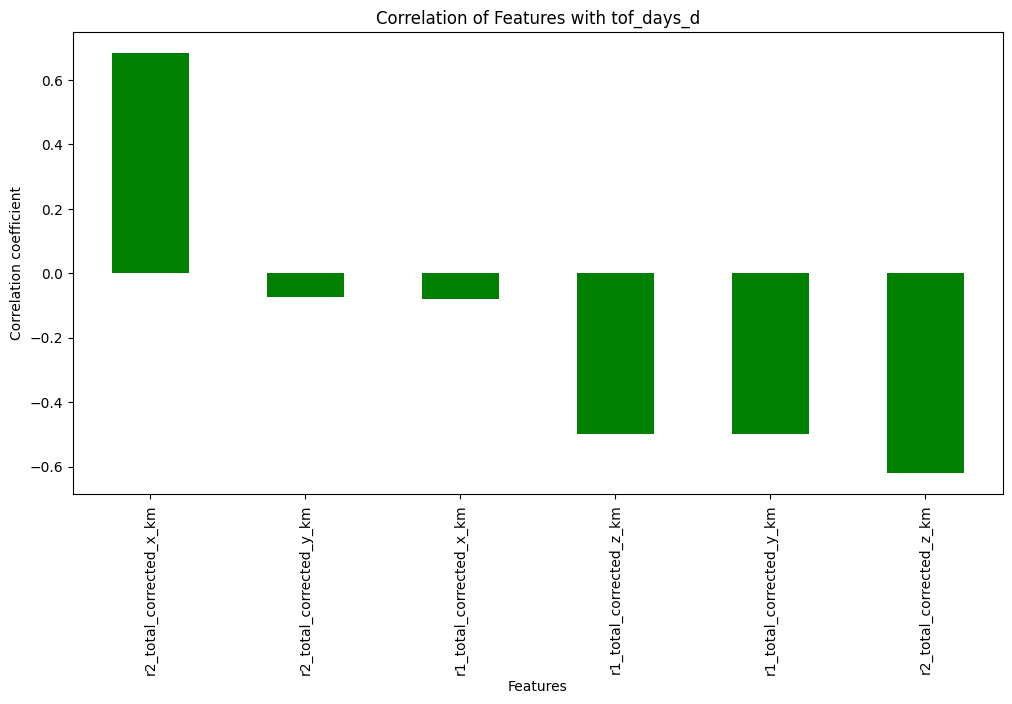

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


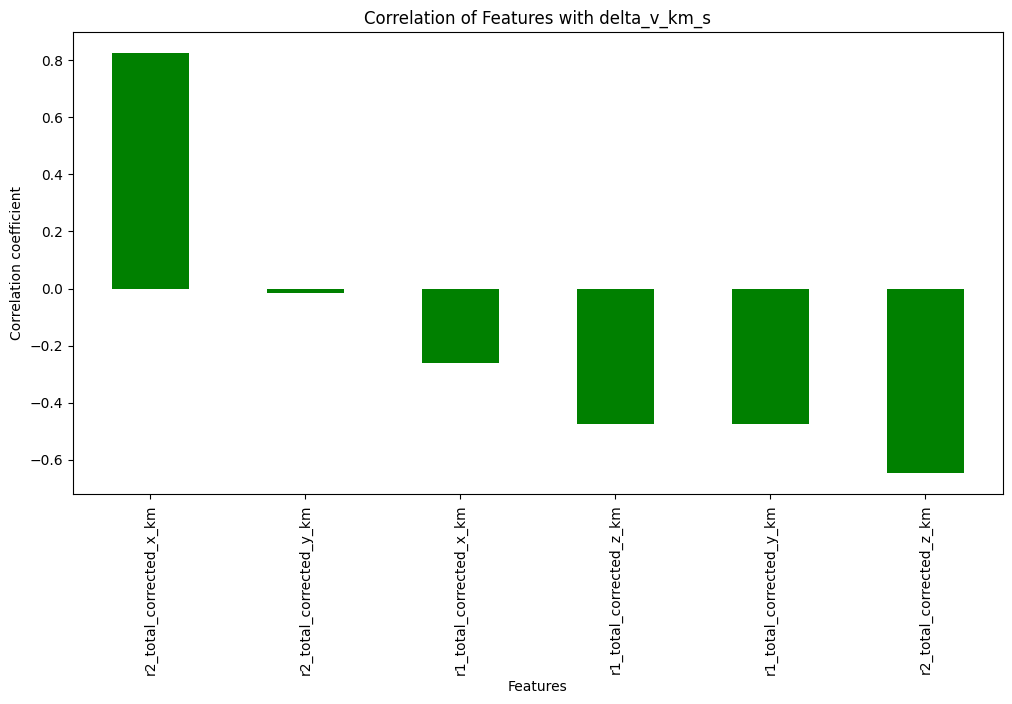

/tmp/ipykernel_2266/3966462517.py:23: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_train.corrwith(y_train[target])


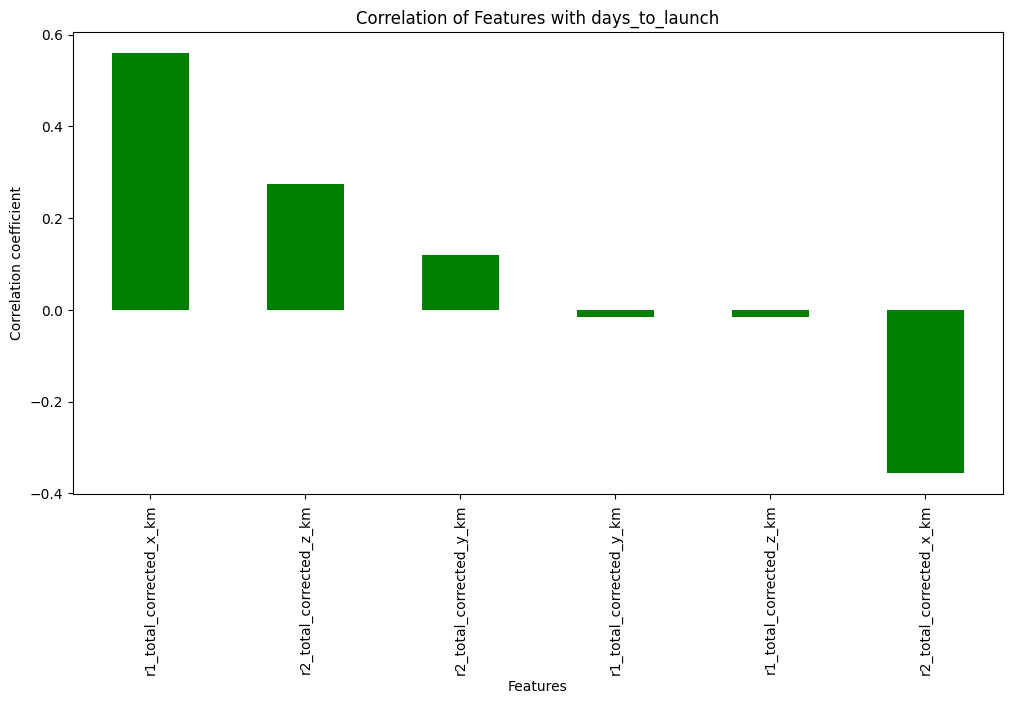

In [23]:
import shap

# Анализ важности признаков с помощью SHAP
for target, model in models.items():
    print(f"SHAP analysis for {target}")

    # Получаем SHAP значения для модели
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # Визуализация SHAP значений
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance for {target}")
    plt.show()

    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f"SHAP Summary Plot for {target}")
    plt.show()

# Визуализация корреляции признаков с целевой переменной
for target in target_columns:
    plt.figure(figsize=(12, 6))
    correlation = X_train.corrwith(y_train[target])
    correlation.sort_values(ascending=False).plot(kind='bar', color='green')
    plt.title(f"Correlation of Features with {target}")
    plt.xlabel('Features')
    plt.ylabel('Correlation coefficient')
    plt.show()

SHAP analysis for v1_transfer_x_km_s


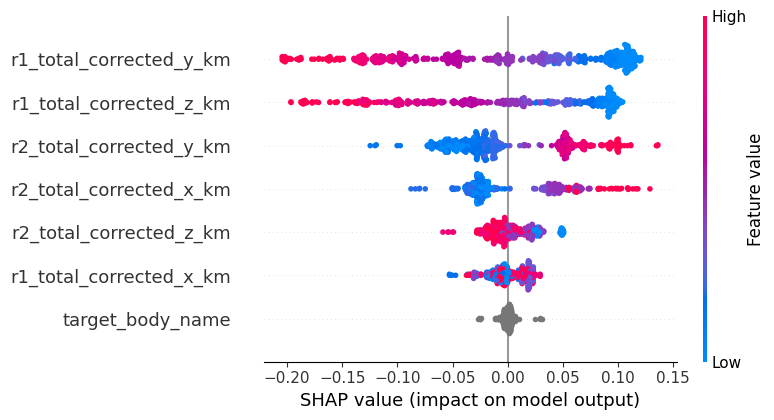

SHAP analysis for v1_transfer_y_km_s


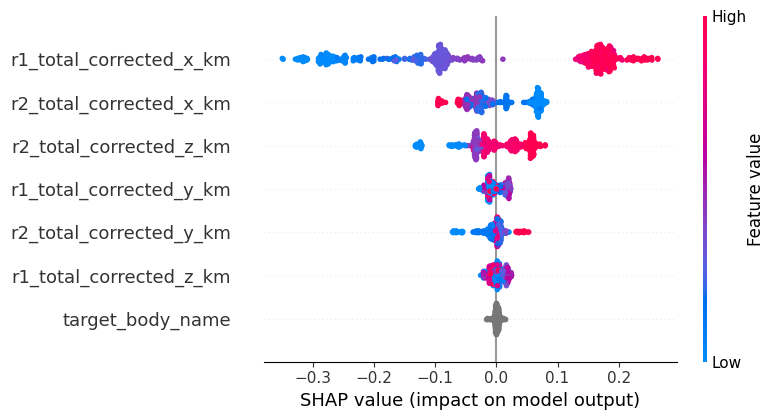

SHAP analysis for v1_transfer_z_km_s


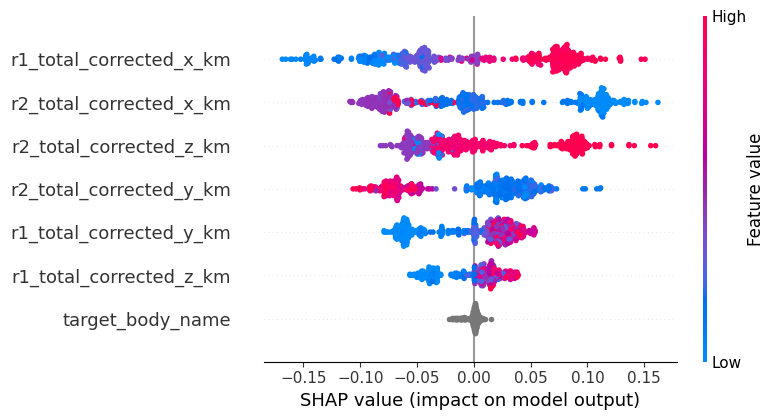

SHAP analysis for v2_transfer_x_km_s


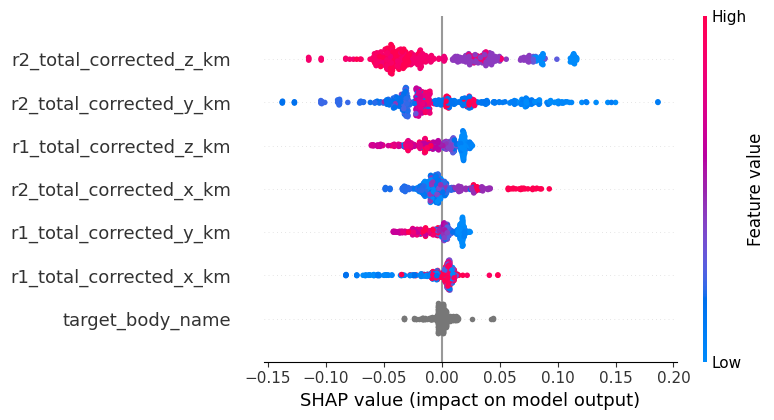

SHAP analysis for v2_transfer_y_km_s


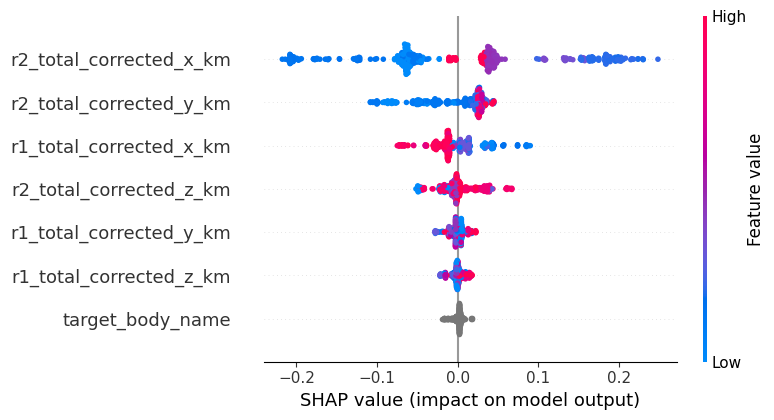

SHAP analysis for v2_transfer_z_km_s


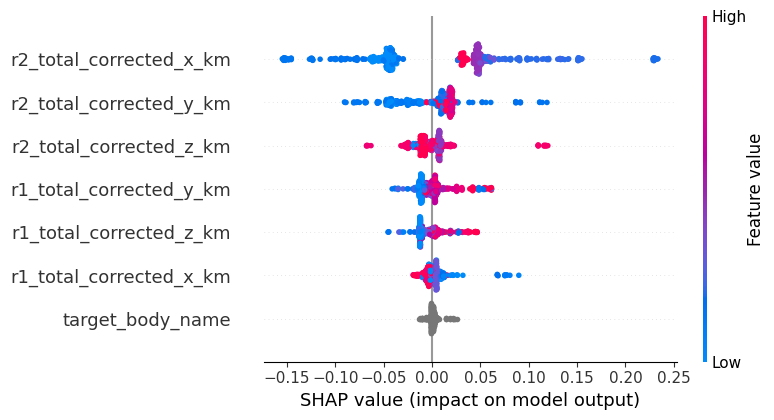

SHAP analysis for tof_days_d


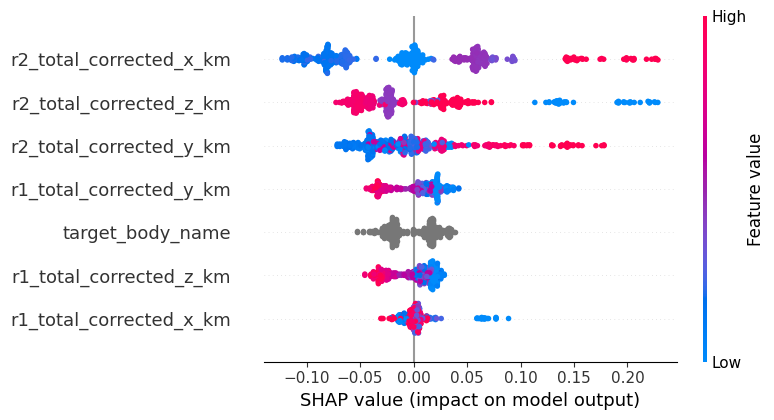

SHAP analysis for delta_v_km_s


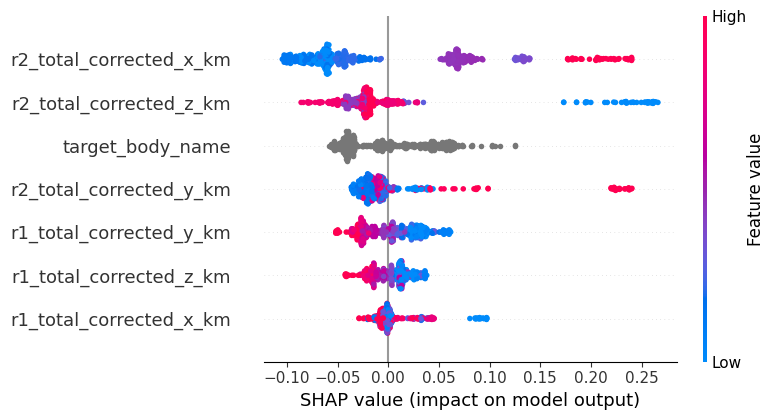

SHAP analysis for days_to_launch


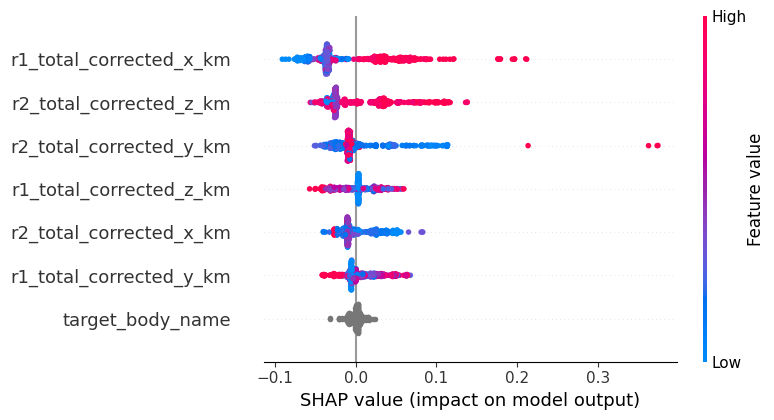

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


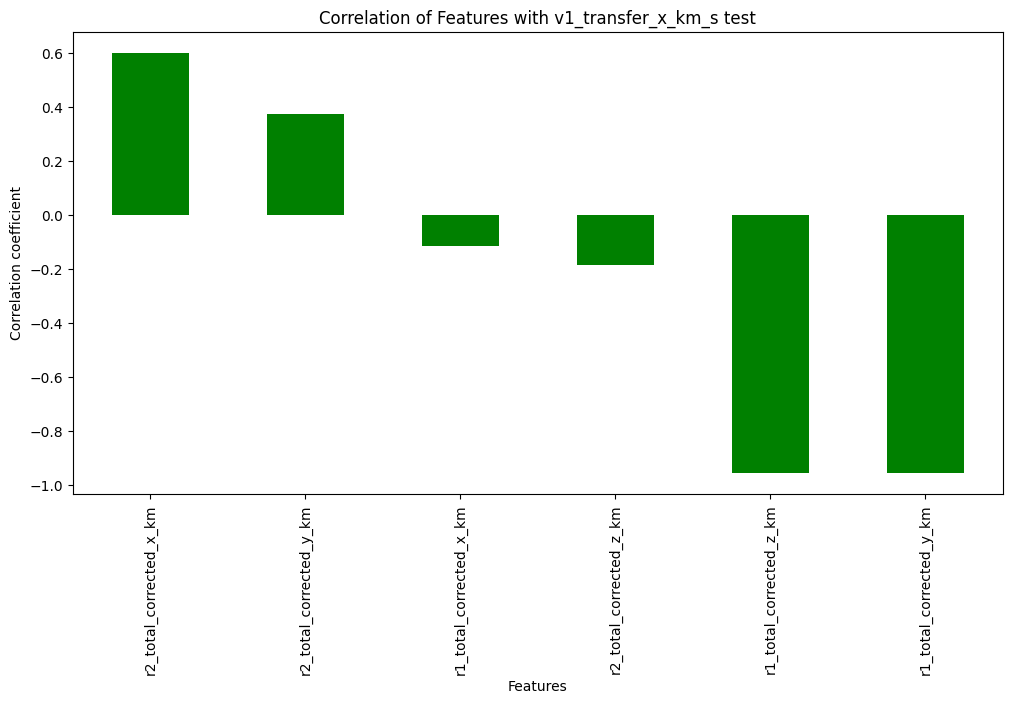

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


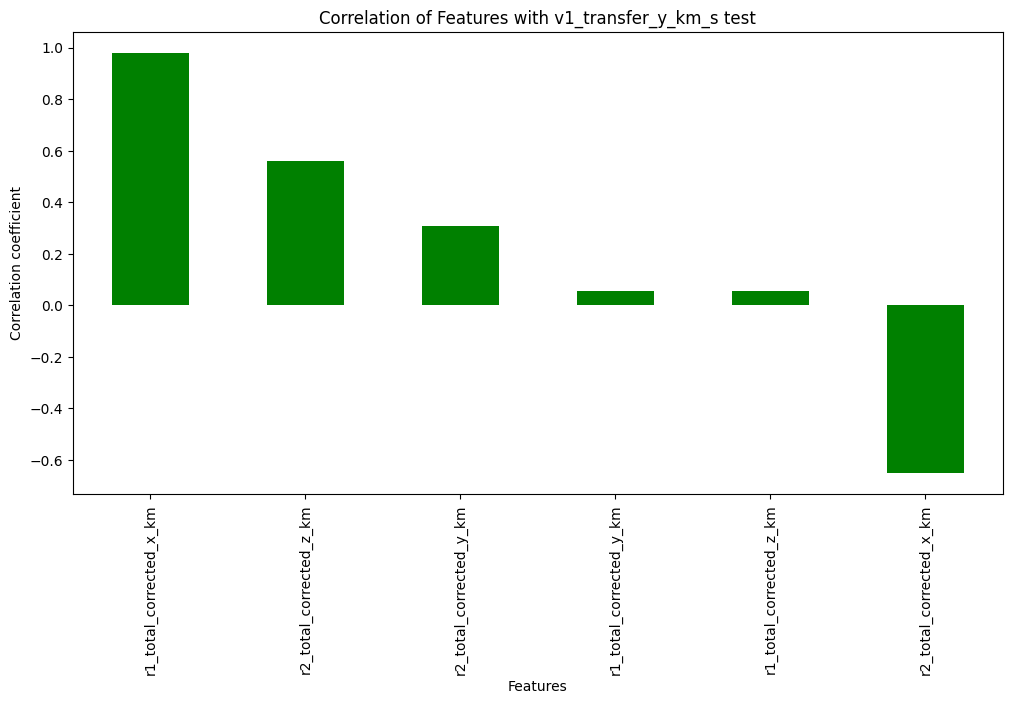

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


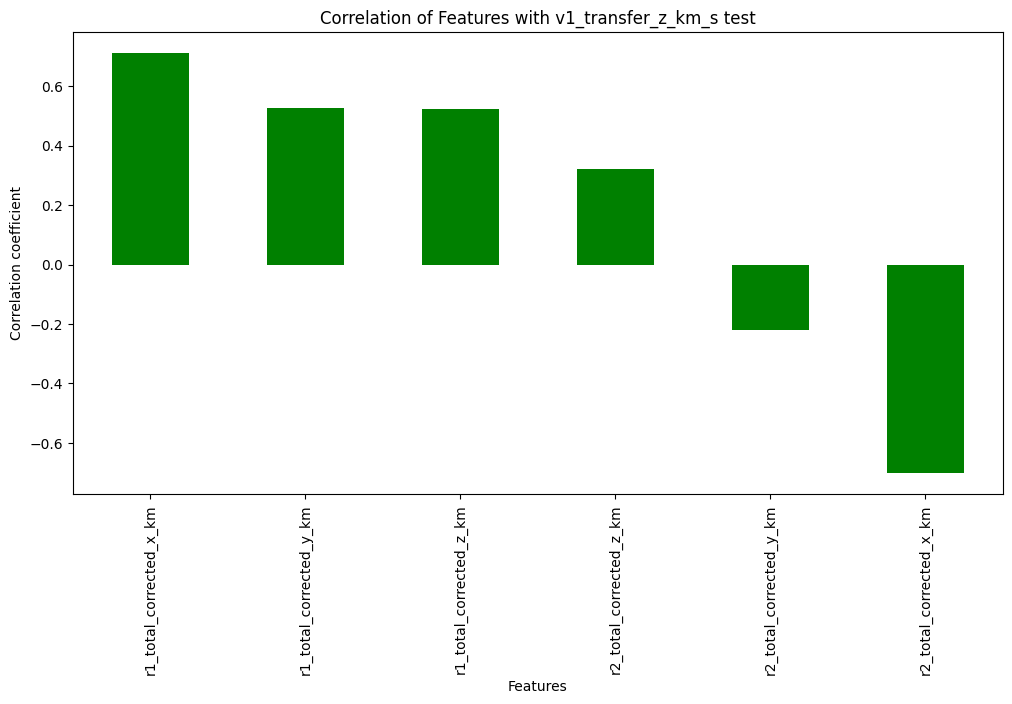

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


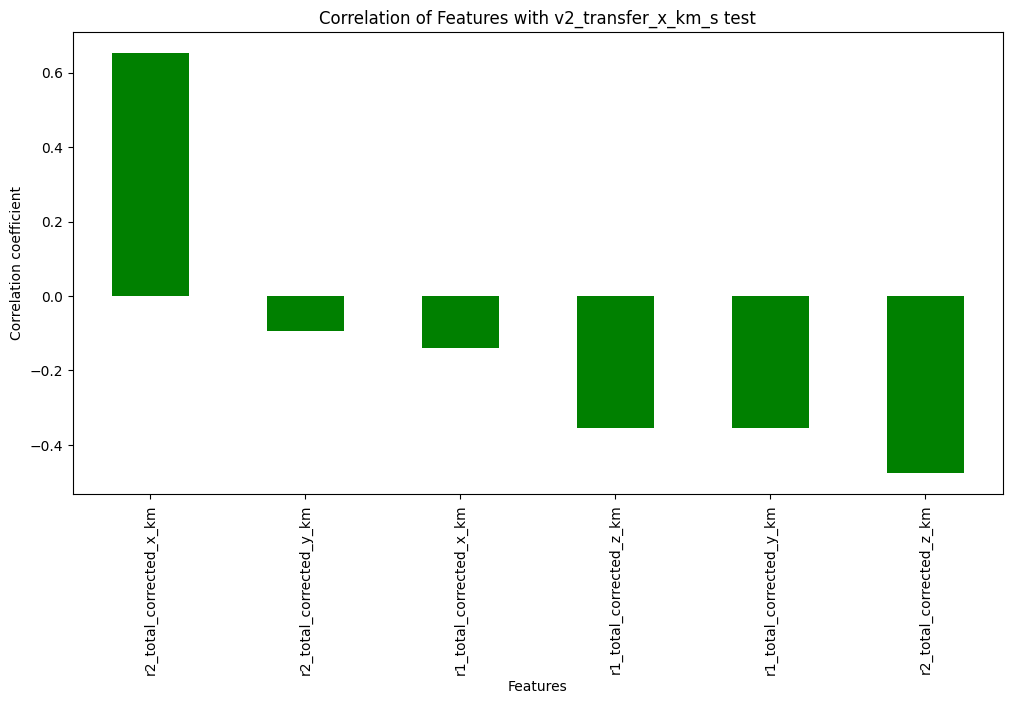

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


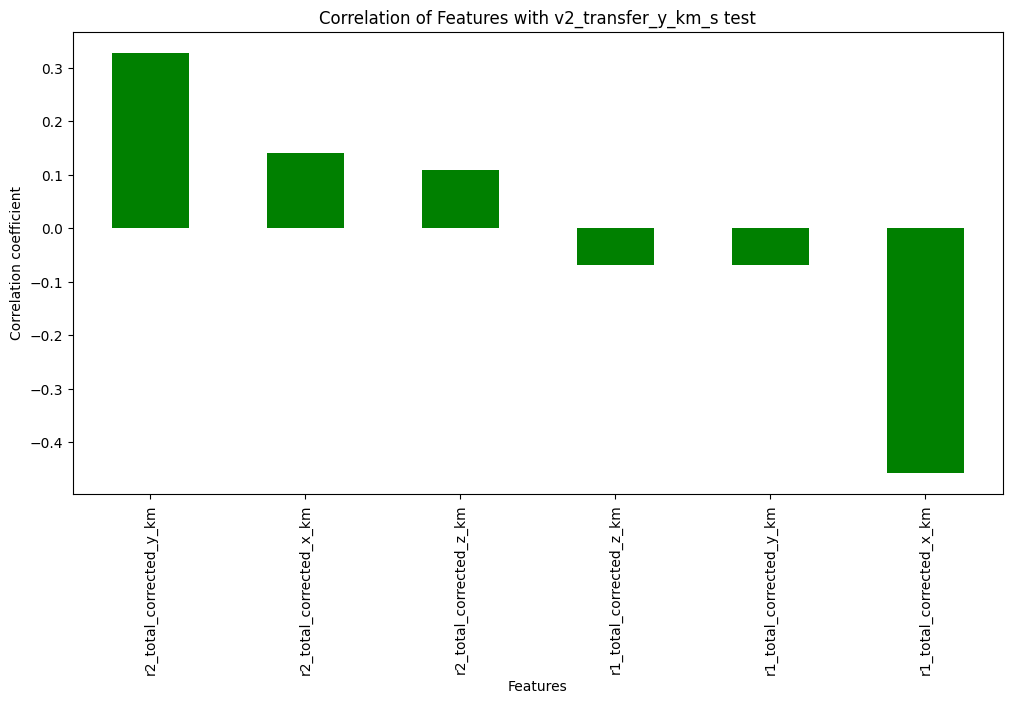

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


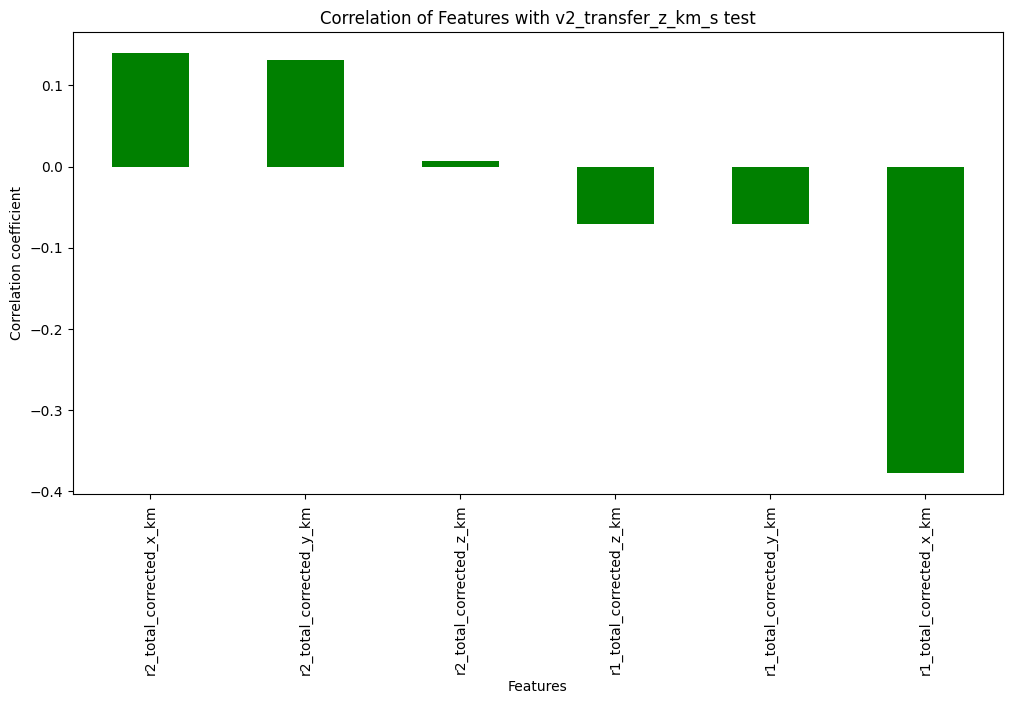

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


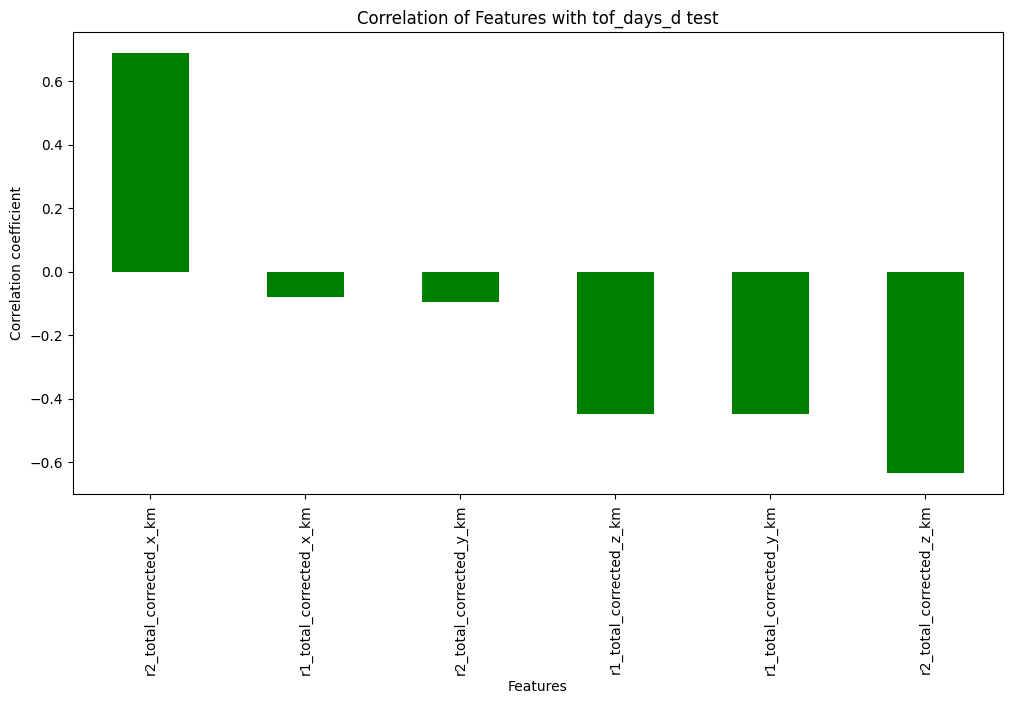

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


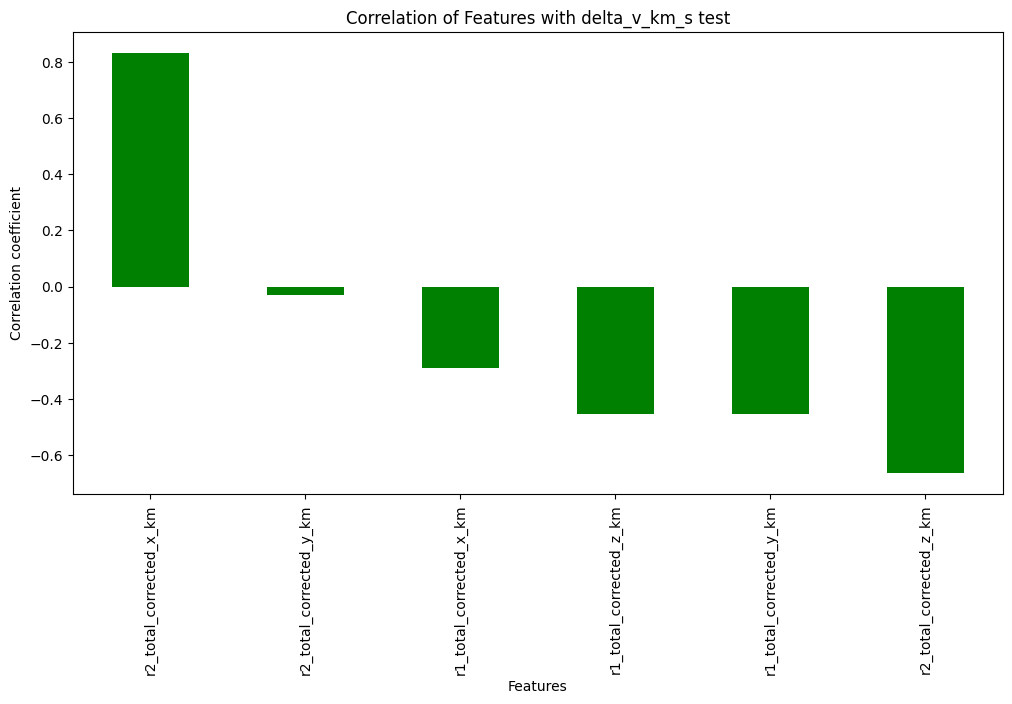

/tmp/ipykernel_2266/1095589582.py:22: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X_test.corrwith(y_test[target])


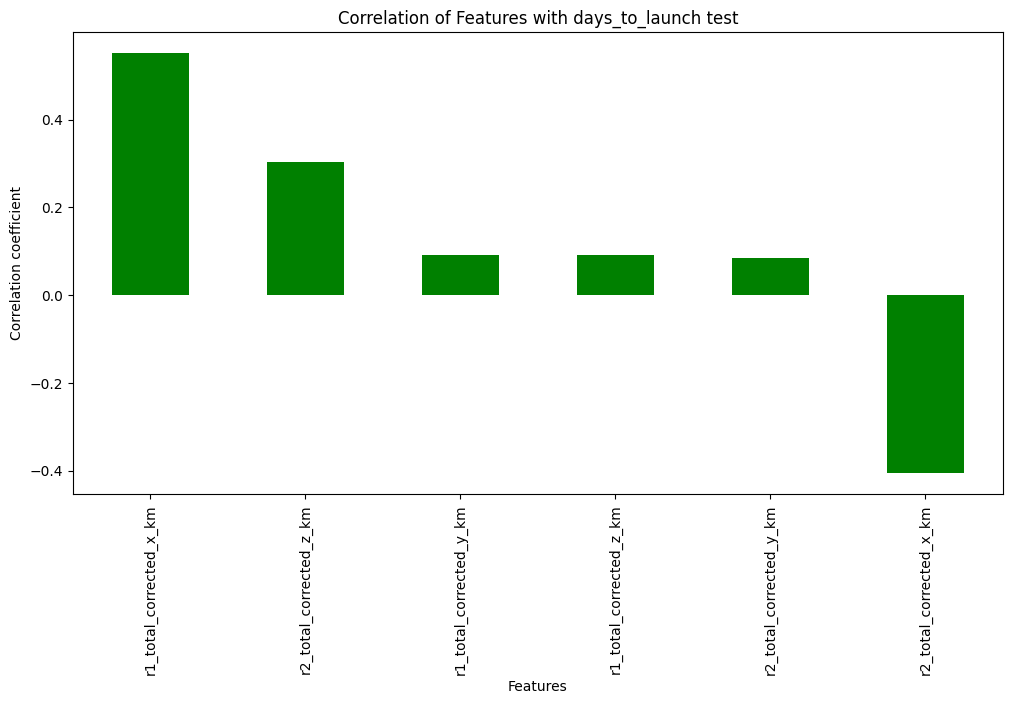

In [ ]:
# Анализ важности признаков с помощью SHAP
for target, model in models.items():
    print(f"SHAP analysis for {target}")

    explainer = shap.Explainer(model)

    # Получение значений SHAP для тестового набора данных
    shap_values = explainer(X_test)

    # Преобразование значений SHAP в DataFrame для удобства
    shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

    # Сохранение значений SHAP в CSV файл
    shap_path = os.path.join(save_dir3, "shap_values.csv")
    shap_df.to_csv(shap_path, index=False)

    # Визуализация значений SHAP
    shap.summary_plot(shap_values, X_test)

# Визуализация корреляции признаков с целевой переменной
for target in target_columns:
    plt.figure(figsize=(12, 6))
    correlation = X_test.corrwith(y_test[target])
    correlation.sort_values(ascending=False).plot(kind='bar', color='green')
    plt.title(f"Correlation of Features with {target} test")
    plt.xlabel('Features')
    plt.ylabel('Correlation coefficient')
    plt.show()

In [24]:
# Примерные данные, которые могут быть введены пользователем
target_body_name = 'Mars'  # Целевая планета
orbit_altitude_km = 250  # Средняя орбитальная высота (приблизительно 250 км)
semi_major_axis_km = 6578 + 250  # Большая полуось орбиты (Земной радиус + высота орбиты)
eccentricity = 0.0  # Эксцентриситет (почти круговая орбита)
argument_of_periapsis = 0  # Аргумент перицентра (не имеет значения для круговой орбиты)
longitude_of_ascending_node = 45  # Долгота восходящего узла (примерное значение)
inclination = 26  # Наклонение (приблизительное значение, для MRO около 26°)
mean_anomaly = 0  # Средняя аномалия (может быть 0 на начальной стадии)

# Подгрузка радиус-векторов
r1_total_corrected_x_km = -27587753.30440232
r1_total_corrected_y_km = 132045390.22375594
r1_total_corrected_z_km = 57262400.737300016
r2_total_corrected_x_km = 91424013.73162754
r2_total_corrected_y_km = -172373648.12479874
r2_total_corrected_z_km = -81501610.20571628

# Преобразование данных для ввода в модель 
user_input = pd.DataFrame({
    'target_body_name': [target_body_name],
    'r1_total_corrected_x_km': [r1_total_corrected_x_km],
    'r1_total_corrected_y_km': [r1_total_corrected_y_km],
    'r1_total_corrected_z_km': [r1_total_corrected_z_km],
    'r2_total_corrected_x_km': [r2_total_corrected_x_km],
    'r2_total_corrected_y_km': [r2_total_corrected_y_km],
    'r2_total_corrected_z_km': [r2_total_corrected_z_km]
})

predictions = {}

# Получаем предсказания для каждой целевой переменной
for target, model in models.items():
    y_pred = model.predict(user_input)
    
    # Денормализация предсказаний 
    if target in scalers:
        y_pred_denormalized = scalers[target].inverse_transform(y_pred.reshape(-1, 1)).flatten()
    else:
        y_pred_denormalized = y_pred
    
    # Сохраняем предсказанные значения
    predictions[target] = y_pred_denormalized[0]  # Сохраняем первое значение (только один пример)

# Вывод предсказанных значений
print("\nPredicted values:")
for target, value in predictions.items():
    print(f" - {target}: {value}")



Predicted values:
 - v1_transfer_x_km_s: -33.59885590556067
 - v1_transfer_y_km_s: -1.5899413511137583
 - v1_transfer_z_km_s: 2.8460838746664363
 - v2_transfer_x_km_s: 17.35087275116538
 - v2_transfer_y_km_s: 17.038541693383234
 - v2_transfer_z_km_s: 4.980940771460747
 - tof_days_d: 360.6403743212923
 - delta_v_km_s: 13.563820385646643
 - days_to_launch: 2.1401754903417043


In [26]:
feature_importances = model.get_feature_importance()
feature_names = X_train.columns  # Предполагается, что X_train - это DataFrame

   # Создание DataFrame для хранения важности признаков
importance_df = pd.DataFrame({
       'Feature': feature_names,
       'Importance': feature_importances
   })

   # Сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                   Feature  Importance
5  r2_total_corrected_y_km   28.453311
1  r1_total_corrected_x_km   23.523952
6  r2_total_corrected_z_km   15.269131
3  r1_total_corrected_z_km   12.894464
4  r2_total_corrected_x_km   10.281876
2  r1_total_corrected_y_km    8.505886
0         target_body_name    1.071380


In [ ]:
importance_path = os.path.join(save_dir3, "feature_importance.csv")
importance_df.to_csv(importance_path, index=False, sep=';', encoding='utf-8')